В цьому ноутбуці ми проведемо дослідницький аналіз даних про історичні платежі по кредитам клієнтами.

[Опис колонок в даних тут.](https://drive.google.com/file/d/1Yp2aOdC33QFAVfTyxav_gKGwi4M9VN1Z/view?usp=sharing)

Цільова змінна TARGET тут має наступне значення: 1 – клієнт із труднощами з оплатою: він/вона прострочив платіж понад X днів принаймні одного з перших Y платежів кредиту в нашій вибірці, 0 – усі інші випадки

Задача - виявити, яким клієнтам видавати кредит, а яким - не варто, бо вони з високою імовірністю його не повернуть.

Дані взяті з [Kaggle](https://www.kaggle.com/datasets/gauravduttakiit/loan-defaulter). Прошу використовувати саме ті, які надані в нашому курсі, аби нам бути впевненими, що ми точно працюємо з одними і тими ж даними.

# Імпорт необхідних бібліотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import analyse_numeric_col, hw2_analyse

pd.set_option('display.max.rows',130)
pd.set_option('display.max.columns',130)
pd.set_option('float_format', '{:.2f}'.format)

# Імпорт даних

Вмонтуємо наш диск, якщо Ви працюєте в Google Colab. Якщо працюєте локально, пропустіть наступну клітинку.

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Знайдемо, де лежать наші файли з даними. В мене вони знаходяться тут:

In [3]:
#!ls 'drive/MyDrive/Machine Learning для людей/data/credit'

Якщо треба зчитати опис, то робимо це аналогічно.

In [4]:
descr = pd.read_csv("columns_description.csv")

In [5]:
descr.loc[1].Description

'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'

Зчитуємо дані.

In [6]:
df = pd.read_csv("application_data.csv.zip")

In [7]:
# Огляд декількох записів з датафрейму
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,351000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,-3648.00,-2120,NaN,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.01,"Stone, brick",No,2.00,2.00,2.00,2.00,-1134.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,1129500.00,Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,-1186.00,-291,NaN,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,NaN,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.99,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0,Revolving loans,M,Y,Y,0,67500.00,135000.00,6750.00,135000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01,-19046,-225,-4260.00,-2531,26.00,1,1,1,1,1,0,Laborers,1.00,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.56,0.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,-815.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.0

# Перевірка структури даних

In [8]:
df.info(verbose = True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

In [9]:
df.shape

(307511, 122)

Маємо ~307k рядків та 122 колонки.

## Статистичний звіт для числових змінних

In [10]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.00,307511.00,307511.00,307511.00,307511.00,307499.00,307233.00,307511.00,307511.00,307511.00,307511.00,307511.00,104582.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307509.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,134133.00,306851.00,246546.00,151450.00,127568.00,157504.00,103023.00,92646.00,143620.00,152683.00,154491.00,98869.00,124921.00,97312.00,153161.00,93997.00,137829.00,151450.00,127568.00,157504.00,103023.00,92646.00,143620.00,152683.00,154491.00,98869.00,124921.00,97312.00,153161.00,93997.00,137829.00,151450.00,127568.00,157504.00,103023.00,92646.00,143620.00,152683.00,154491.00,98869.00,124921.00,97312.00,153161.00,93997.00,137829.00,159080.00,306490.00,306490.00,306490.00,306490.00,307510.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,265992.00,265992.00,265992.00,265992.00,265992.00,265992.00
mean,278180.52,0.08,0.42,168797.92,599026.00,27108.57,538396.21,0.02,-16037.00,63815.05,-4986.12,-2994.20,12.06,1.00,0.82,0.20,1.00,0.28,0.06,2.15,2.05,2.03,12.06,0.02,0.05,0.04,0.08,0.23,0.18,0.50,0.51,0.51,0.12,0.09,0.98,0.75,0.04,0.08,0.15,0.23,0.23,0.07,0.10,0.11,0.01,0.03,0.11,0.09,0.98,0.76,0.04,0.07,0.15,0.22,0.23,0.06,0.11,0.11,0.01,0.03,0.12,0.09,0.98,0.76,0.04,0.08,0.15,0.23,0.23,0.07,0.10,0.11,0.01,0.03,0.10,1.42,0.14,1.41,0.10,-962.86,0.00,0.71,0.00,0.02,0.09,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.01,0.01,0.03,0.27,0.27,1.90
std,102790.18,0.27,0.72,237123.15,402490.78,14493.74,369446.46,0.01,4363.99,141275.77,3522.89,1509.45,11.94,0.00,0.38,0.40,0.04,0.45,0.23,0.91,0.51,0.50,3.27,0.12,0.22,0.20,0.27,0.42,0.38,0.21,0.19,0.19,0.11,0.08,0.06,0.11,0.08,0.13,0.10,0.14,0.16,0.08,0.09,0.11,0.05,0.07,0.11,0.08,0.06,0.11,0.07,0.13,0.10,0.14,0.16,0.08,0.10,0.11,0.05,0.07,0.11,0.08,0.06,0.11,0.08,0.13,0.10,0.15,0.16,0.08,0.09,0.11,0.05,0.07,0.11,2.40,0.45,2.38,0.36,826.81,0.

# Аналіз категоріальних змінних

In [11]:
df.select_dtypes(include = "object").columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [12]:
# Перевірка кількості категоріальних змінних
len(df.select_dtypes(include = "object").columns)

16

Дані містять 16 `categorical` змінних

# Аналіз числових змінних

In [13]:
number_df = df.select_dtypes(include="number")

In [14]:
number_df.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=106)

In [15]:
# Перевірка кількості числових змінних
len(number_df.columns)

106

Дані міятять 106 `numerical` змінних

In [16]:
number_df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,202500.00,406597.50,24700.50,351000.00,0.02,-9461,-637,-3648.00,-2120,NaN,1,1,0,1,1,0,1.00,2,2,10,0,0,0,0,0,0,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.01,2.00,2.00,2.00,2.00,-1134.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,0,270000.00,1293502.50,35698.50,1129500.00,0.00,-16765,-1188,-1186.00,-291,NaN,1,1,0,1,1,0,2.00,1,1,11,0,0,0,0,0,0,0.31,0.62,NaN,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.99,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,0.07,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0,0,67500.00,135000.00,6750.00,135000.00,0.01,-19046,-225,-4260.00,-2531,26.00,1,1,1,1,1,0,1.00,2,2,9,0,0,0,0,0,0,NaN,0.56,0.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,-815.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
3,100006,0,0,135000.00,312682.50,29686.50,297000.00,0.01,-19005,-3039,-9833.00,-2437,NaN,1,1,0,1,0,0,2.00,2,2,17,0,0,0,0,0,0,NaN,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,0.00,2.00,0.00,-617.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.00,513000.00,21865.50,513000.00,0.03,-19932,-3038,-4311.00,-3458,NaN,1,1,0,1,0,0,1.00,2,2,11,0,0,0,0,1,1,NaN,0.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,-1106.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0

# Робота з некоректними типами даних

Перевірка, чи немає у нас стовпця з неправильним типом даних

In [17]:
df.dtypes

SK_ID_CURR                        int64
TARGET                            int64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64


Дивлячись на дані та відповідні їм типи даних, можна змінити тип стовпчика SKU.

In [18]:
df['SK_ID_CURR'] = df['SK_ID_CURR'].astype("str")

Також ми можемо змінити всі стовпці `flag` на тип даних, який є більш економний для зберігання.

In [19]:
df['FLAG_DOCUMENT_21'].value_counts()

FLAG_DOCUMENT_21
0    307408
1       103
Name: count, dtype: int64

Ось скільки пам'яті в Мб займають наші дані зараз.

In [20]:
df.memory_usage().sum()/1024/1024

286.22710037231445

In [21]:
'flag' in 'SK_ID_CURR'.lower()

False

In [22]:
flag_cols = ['flag' in col.lower() for col in df.columns]

In [23]:
df[df.columns[flag_cols]].head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,N,Y,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,N,N,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Y,Y,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,N,Y,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,N,Y,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
df[df.columns[flag_cols]].nunique()

FLAG_OWN_CAR        2
FLAG_OWN_REALTY     2
FLAG_MOBIL          2
FLAG_EMP_PHONE      2
FLAG_WORK_PHONE     2
FLAG_CONT_MOBILE    2
FLAG_PHONE          2
FLAG_EMAIL          2
FLAG_DOCUMENT_2     2
FLAG_DOCUMENT_3     2
FLAG_DOCUMENT_4     2
FLAG_DOCUMENT_5     2
FLAG_DOCUMENT_6     2
FLAG_DOCUMENT_7     2
FLAG_DOCUMENT_8     2
FLAG_DOCUMENT_9     2
FLAG_DOCUMENT_10    2
FLAG_DOCUMENT_11    2
FLAG_DOCUMENT_12    2
FLAG_DOCUMENT_13    2
FLAG_DOCUMENT_14    2
FLAG_DOCUMENT_15    2
FLAG_DOCUMENT_16    2
FLAG_DOCUMENT_17    2
FLAG_DOCUMENT_18    2
FLAG_DOCUMENT_19    2
FLAG_DOCUMENT_20    2
FLAG_DOCUMENT_21    2
dtype: int64

Типи даних в pandas взяті з numpy, і ось тут список всіх типів даних в numpy:

https://numpy.org/doc/stable/user/basics.types.html

Кожен тип даних займає певну кількість байт у пам'яті. Давайте з'ясуємо, скільки займає 1 тип int8 та 1 тип int64 і скільки пам'яті ми заощадимо, якщо змінимо тип.

In [25]:
import numpy as np
from sys import getsizeof

In [26]:
getsizeof(np.int64(1))

32

In [27]:
getsizeof(np.int8(1))

25

In [28]:
7 * df.shape[0] * sum(flag_cols) / 1024 / 1024

57.48000717163086

Отже, ми можемо потенційно заощадити 57 Мб пам'яті! І трансформувати наш фрейм даних буде простіше. Давайте змінимо тип.


In [29]:
str_flag_cols = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

In [30]:
for col in str_flag_cols:
  df[col] = np.where(df[col]=='Y', 1, 0)

In [31]:
df[str_flag_cols]

,FLAG_OWN_CAR,FLAG_OWN_REALTY
0,0,1
1,0,0
2,1,1
3,0,1
4,0,1
...,...,...
307506,0,0
307507,0,1
307508,0,1
307509,0,1


In [32]:
df[str_flag_cols].nunique()

FLAG_OWN_CAR       2
FLAG_OWN_REALTY    2
dtype: int64

In [33]:
df.columns[flag_cols]

Index(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
       'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
       'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
       'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
       'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'],
      dtype='object')

In [34]:
df[df.columns[flag_cols]] = df[df.columns[flag_cols]].astype('int8')

In [35]:
df.memory_usage().sum()/1024/1024

228.7470932006836

# Робота з пропущеними значеннями

Найпростіше емпіричне правило для опрацювання пропущених значень: якщо пропущених значень більше за 40% - видаляємо колонку, якщо менше за 40% - аналізуємо, як можна заповнити і чи треба.

Зазвичай, якщо відсоток пропущених даних більший за 10 і немає чіткої (яка значно виділяється) моди (найчастішого) значення в даних, то лишаємо дані як є до використання методів машинного навчання. Далі якщо метод вимагає заповення пропущених значень, можемо експериментувати із заповеннями. Також хорошою практикою є створити окрему колонку-флаг (0/1), яка вказує, де були пропущені значення - це буде додаткова ознака для моделі.


Перевіримо, чи немає null-значень в нашому наборі даних

In [36]:
df.isnull().values.any()

True

Порахуємо загальну кількість null-значень в наборі даних

In [37]:
df.isnull().values.sum()

9152465

Сформуємо список із стовпців з null-значеннями

In [38]:
df.columns[df.isnull().any()]

Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'OWN_CAR_AGE',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
       'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE',
       'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
       'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
       'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMI

In [39]:
len(df.columns[df.isnull().any()])

67

Усього `67` стовпців мають одне або більше NULL-значень в даних

## Кількість та відсоток пропущених значень у стовпцях

In [40]:
df.shape

(307511, 122)

In [41]:
df.shape[0]

307511

In [42]:
null_count = df.isnull().sum()
null_percentage = round((df.isnull().sum()/df.shape[0])*100, 2)

In [43]:
null_count

SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE         

In [44]:
null_percentage

SK_ID_CURR                      0.00
TARGET                          0.00
NAME_CONTRACT_TYPE              0.00
CODE_GENDER                     0.00
FLAG_OWN_CAR                    0.00
FLAG_OWN_REALTY                 0.00
CNT_CHILDREN                    0.00
AMT_INCOME_TOTAL                0.00
AMT_CREDIT                      0.00
AMT_ANNUITY                     0.00
AMT_GOODS_PRICE                 0.09
NAME_TYPE_SUITE                 0.42
NAME_INCOME_TYPE                0.00
NAME_EDUCATION_TYPE             0.00
NAME_FAMILY_STATUS              0.00
NAME_HOUSING_TYPE               0.00
REGION_POPULATION_RELATIVE      0.00
DAYS_BIRTH                      0.00
DAYS_EMPLOYED                   0.00
DAYS_REGISTRATION               0.00
DAYS_ID_PUBLISH                 0.00
OWN_CAR_AGE                    65.99
FLAG_MOBIL                      0.00
FLAG_EMP_PHONE                  0.00
FLAG_WORK_PHONE                 0.00
FLAG_CONT_MOBILE                0.00
FLAG_PHONE                      0.00
F

In [45]:
df.shape[0]

307511

In [46]:
null_df = pd.DataFrame({'column_name' : df.columns,'null_count' : null_count,'null_percentage': null_percentage})
null_df

,column_name,null_count,null_percentage
SK_ID_CURR,SK_ID_CURR,0,0.00
TARGET,TARGET,0,0.00
NAME_CONTRACT_TYPE,NAME_CONTRACT_TYPE,0,0.00
CODE_GENDER,CODE_GENDER,0,0.00
FLAG_OWN_CAR,FLAG_OWN_CAR,0,0.00
FLAG_OWN_REALTY,FLAG_OWN_REALTY,0,0.00
CNT_CHILDREN,CNT_CHILDREN,0,0.00
AMT_INCOME_TOTAL,AMT_INCOME_TOTAL,0,0.00
AMT_CREDIT,AMT_CREDIT,0,0.00
AMT_ANNUITY,AMT_ANNUITY,12,0.00


In [47]:
null_df.reset_index(drop = True, inplace = True)
null_df

,column_name,null_count,null_percentage
0,SK_ID_CURR,0,0.00
1,TARGET,0,0.00
2,NAME_CONTRACT_TYPE,0,0.00
3,CODE_GENDER,0,0.00
4,FLAG_OWN_CAR,0,0.00
5,FLAG_OWN_REALTY,0,0.00
6,CNT_CHILDREN,0,0.00
7,AMT_INCOME_TOTAL,0,0.00
8,AMT_CREDIT,0,0.00
9,AMT_ANNUITY,12,0.00


In [48]:
null_df.sort_values(by = 'null_percentage', ascending = False)

,column_name,null_count,null_percentage
76,COMMONAREA_MEDI,214865,69.87
48,COMMONAREA_AVG,214865,69.87
62,COMMONAREA_MODE,214865,69.87
70,NONLIVINGAPARTMENTS_MODE,213514,69.43
56,NONLIVINGAPARTMENTS_AVG,213514,69.43
84,NONLIVINGAPARTMENTS_MEDI,213514,69.43
86,FONDKAPREMONT_MODE,210295,68.39
68,LIVINGAPARTMENTS_MODE,210199,68.35
54,LIVINGAPARTMENTS_AVG,210199,68.35
82,LIVINGAPARTMENTS_MEDI,210199,68.35


## Видалення стовпців з NULL значеннями > 40%

Сформуємо список стовпців з NULL значеннями > 40% у список. Ми видалимо ці стовпці з датафрейму, оскільки в них занадто багато пропущених значень.

In [49]:
columns_to_be_deleted = null_df[null_df['null_percentage'] > 40].column_name.to_list()

In [50]:
columns_to_be_deleted

['OWN_CAR_AGE',
 'EXT_SOURCE_1',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'TOTALAREA_MOD

In [51]:
len(columns_to_be_deleted)

49

Всього потрібно видалити `49` стовпців. Видалення їх з основного датафрейму **`df`**

In [52]:
df.drop(columns = columns_to_be_deleted, inplace = True)

Перевірка підрахунку стовпців після видалення. Мало б залишитись лише `73` стовпці

In [53]:
df.shape

(307511, 73)

## Перевірка стовпців з NULL значеннями < 40%

Створення датафрейму `null_df_under40` зі стовпцями, де відсоток пропущених значеннь менше 40%

In [54]:
null_df_under40 = null_df[null_df['null_percentage'] < 40]

In [55]:
null_df_under40['AMT_REQ_CREDIT_BUREAU_YEAR' == null_df_under40['column_name']]

,column_name,null_count,null_percentage
121,AMT_REQ_CREDIT_BUREAU_YEAR,41519,13.50


In [56]:
null_df_under40.sort_values(by = 'null_percentage', ascending = False)

,column_name,null_count,null_percentage
28,OCCUPATION_TYPE,96391,31.35
43,EXT_SOURCE_3,60965,19.83
121,AMT_REQ_CREDIT_BUREAU_YEAR,41519,13.50
120,AMT_REQ_CREDIT_BUREAU_QRT,41519,13.50
119,AMT_REQ_CREDIT_BUREAU_MON,41519,13.50
118,AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.50
117,AMT_REQ_CREDIT_BUREAU_DAY,41519,13.50
116,AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.50
11,NAME_TYPE_SUITE,1292,0.42
91,OBS_30_CNT_SOCIAL_CIRCLE,1021,0.33


Опрацюємо кожну з колонок.

### Аналіз стовпця `OCCUPATION_TYPE`

- нульові значення = 31.35%

In [57]:
df['OCCUPATION_TYPE'].value_counts()

OCCUPATION_TYPE
Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: count, dtype: int64

Заміна NULL-значень на категорією `Unknown`

In [58]:
#df['OCCUPATION_TYPE'].fillna(value = 'Unknown', inplace = True)
df.fillna({'OCCUPATION_TYPE': 'Unknown'}, inplace = True)

FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['OCCUPATION_TYPE'].fillna(value = 'Unknown', inplace = True)

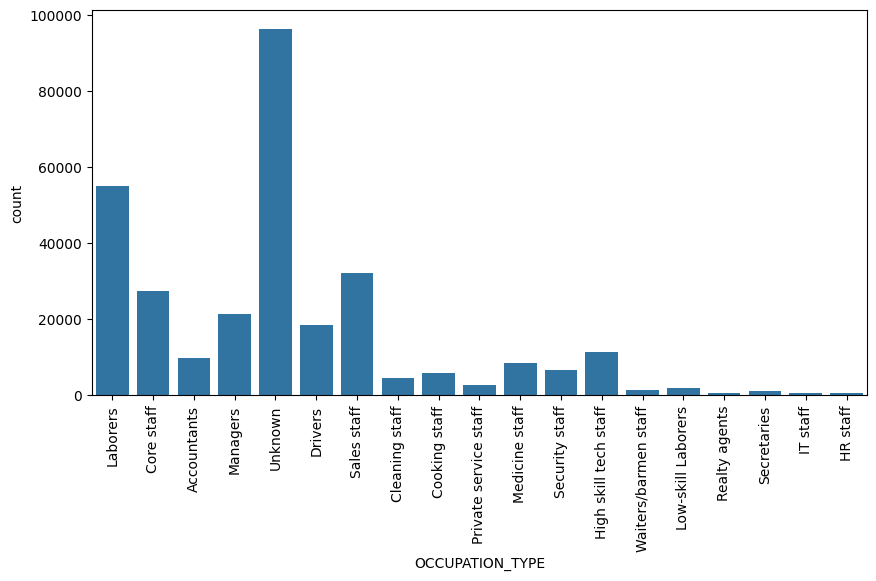

In [59]:
plt.figure(figsize = (10,5))
sns.countplot(data = df, x = "OCCUPATION_TYPE")
plt.xticks(rotation = 90)
plt.show()

**Спостереження**
- Якщо поглянути на графік, то найбільшу кількість заявників на кредит мають `Laborers`
- Для імпутації краще залишити дані як є (пропущені значення становлять 31,35%) і не проводити імпутацію за якоюсь константою, як-от мода або мін/макс медіана, якщо це числовий стовпчик, оскільки це може викривити дані в подальших розрахунках.

Існує також можливість імпутації за допомогою більш "розумних" методів, але ми вивчимо їх пізніше, а зараз ми робимо те, що можемо, за допомогою деяких найпростіших перетворень.

### Аналіз стовпця `EXT_SOURCE_3`

- пропущені значення = 19.83%

In [60]:
df.EXT_SOURCE_3.value_counts().head()

EXT_SOURCE_3
0.75    1460
0.71    1315
0.69    1276
0.67    1191
0.65    1154
Name: count, dtype: int64

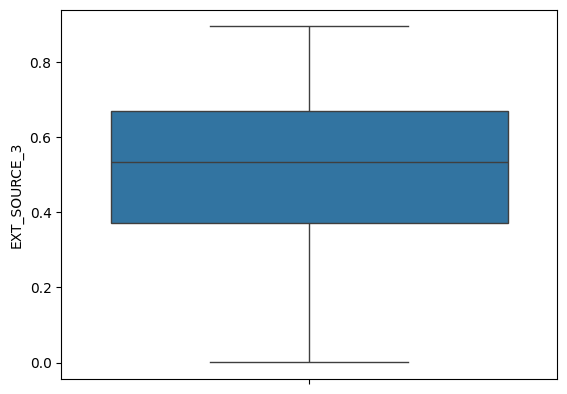

In [61]:
sns.boxplot(df.EXT_SOURCE_3)
plt.show()

Отримання процентильних значень для `EXT_SOURCE_3`

In [62]:
df.EXT_SOURCE_3.quantile(q = [0.25,0.5,0.75,1])

0.25   0.37
0.50   0.54
0.75   0.67
1.00   0.90
Name: EXT_SOURCE_3, dtype: float64

Найбільш повторюване значення в `EXT_SOURCE_3

In [63]:
df.EXT_SOURCE_3.mode()[0]

0.746300213050371

Перевірка середнього значення `EXT_SOURCE_3`

In [64]:
df.EXT_SOURCE_3.mean()

0.5108529061799658

**Спостереження**
-  Дивлячись на діагараму розмаху, медіана становить 0,535276
-  Найчастіше повторюване значення - 0,74630
-  Середнє значення - 0,51085
-  Хоча середнє та медіана є ближчими і можуть бути використані для імплікації, оскільки відсутнє відсоткове значення є більшим (19,83%), краще залишити дані як є і не проводити імплікації. Якщо метод вимагає імплікації, ми можемо імплікувати дані за допомогою медіани і створити ще один стовпчик, в якому буде позначено, які значення були імпліковані.

# ДЗ 1. Аналіз стовпців `AMT_REQ_CREDIT_BUREAU` з пропущеними значеннями

Виведіть середнє, моду, медіану та відсоток відсутніх даних для настуних колонок:

-  `AMT_REQ_CREDIT_BUREAU_YEAR`
-	`AMT_REQ_CREDIT_BUREAU_QRT`
-	`AMT_REQ_CREDIT_BUREAU_MON`
-	`AMT_REQ_CREDIT_BUREAU_WEEK`
-	`AMT_REQ_CREDIT_BUREAU_DAY`
-	`AMT_REQ_CREDIT_BUREAU_HOUR`

На основі виведених даних напишіть висновок про те, чи варто заповнювати пусті значення і якщо так, то яким чином?

In [65]:
columns_hw1 = [col for col in df.columns if 'AMT_REQ_CREDIT_BUREAU' in col]
analyse_numeric_col(df, null_percentage, null_count, columns_hw1)

=== AMT_REQ_CREDIT_BUREAU_HOUR ===
Min: 0.0
Mean: 0.006402448193930645
Median: 0.0
Max: 4.0
Mode: 0.0
Null Percentage: 13.5%
Null Count: 41519
=== AMT_REQ_CREDIT_BUREAU_DAY ===
Min: 0.0
Mean: 0.0070002105326475985
Median: 0.0
Max: 9.0
Mode: 0.0
Null Percentage: 13.5%
Null Count: 41519
=== AMT_REQ_CREDIT_BUREAU_WEEK ===
Min: 0.0
Mean: 0.0343619356973142
Median: 0.0
Max: 8.0
Mode: 0.0
Null Percentage: 13.5%
Null Count: 41519
=== AMT_REQ_CREDIT_BUREAU_MON ===
Min: 0.0
Mean: 0.26739526000781977
Median: 0.0
Max: 27.0
Mode: 0.0
Null Percentage: 13.5%
Null Count: 41519
=== AMT_REQ_CREDIT_BUREAU_QRT ===
Min: 0.0
Mean: 0.26547414959848414
Median: 0.0
Max: 261.0
Mode: 0.0
Null Percentage: 13.5%
Null Count: 41519
=== AMT_REQ_CREDIT_BUREAU_YEAR ===
Min: 0.0
Mean: 1.899974435321363
Median: 1.0
Max: 25.0
Mode: 0.0
Null Percentage: 13.5%
Null Count: 41519


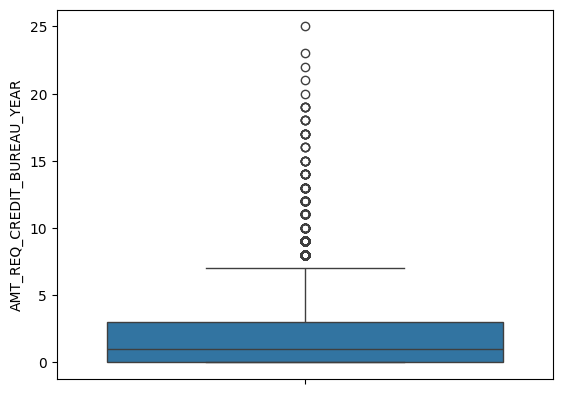

In [66]:
sns.boxplot(df.AMT_REQ_CREDIT_BUREAU_YEAR )
plt.show()

In [67]:
df.AMT_REQ_CREDIT_BUREAU_YEAR.quantile(q = [0.25,0.5,0.75,1])

0.25    0.00
0.50    1.00
0.75    3.00
1.00   25.00
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: float64

In [68]:
df[df.AMT_REQ_CREDIT_BUREAU_YEAR.isnull()]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
3,100006,0,Cash loans,F,0,1,0,135000.00,312682.50,29686.50,297000.00,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.01,-19005,-3039,-9833.00,-2437,1,1,0,1,0,0,Laborers,2.00,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.65,NaN,2.00,0.00,2.00,0.00,-617.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
9,100012,0,Revolving loans,M,0,1,0,135000.00,405000.00,20250.00,405000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-14469,-2019,-14437.00,-3992,1,1,0,1,0,0,Laborers,1.00,2,2,THURSDAY,8,0,0,0,0,0,0,Electricity,0.75,NaN,2.00,0.00,2.00,0.00,-1673.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
14,100018,0,Cash loans,F,0,1,0,189000.00,773680.50,32778.00,679500.00,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.01,-14583,-203,-615.00,-2056,1,1,0,1,0,0,Laborers,2.00,2,1,MONDAY,9,0,0,0,0,0,0,Transport: type 2,0.64,NaN,0.00,0.00,0.00,0.00,-188.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
17,100021,0,Revolving loans,F,0,1,1,81000.00,270000.00,13500.00,270000.00,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.01,-9776,-191,-4143.00,-2427,1,1,0,1,0,0,Laborers,3.00,2,2,MONDAY,10,0,0,0,1,1,0,Construction,0.68,NaN,4.00,0.00,4.00,0.00,-2811.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
20,100024,0,Revolving loans,M,1,1,0,135000.00,427500.00,21375.00,427500.00,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.02,-18252,-4286,-298.00,-1800,1,1,0,1,0,0,Laborers,2.00,2,2,FRIDAY,13,0,0,0,0,0,0,Self-employed,0.11,NaN,0.00,0.00,0.00,0.00,-296.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307484,456228,0,Cash loans,F,1,0,0,540000.00,545040.00,35617.50,450000.00,Unaccompanied,Commercial associate,Secondary / secondary special,Married,Rented apartment,0.03,-12847,-328,-2531.00,-35,1,1,0,1,1,1,Managers,2.00,1,1,MONDAY,13,0,0,0,0,0,0,Business Entity Type 3,0.74,NaN,0.00,0.00,0.00,0.00,-1578.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307501,456245,0,Cash loans,F,0,1,3,81000.00,269550.00,11871.00,225000.00,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.01,-12961,-1046,-1398.00,-3780,1,1,1,

#### Висновок:
Середнє, медіана та мода близькі до нуля для всіх AMT_REQ_CREDIT_BUREAU_* колонок крім AMT_REQ_CREDIT_BUREAU_YEAR:
 - середнє 1.899974435321363
 - медіана 1.0
 - мода 0.0
 
Відсоток пустих значень всюди однаковий: 13,5%
Якщо метод машинного навчання вимагає заповнення пустих значень - я б заповнив нулями крім колонки AMT_REQ_CREDIT_BUREAU_YEAR. Для цієї колонки у нас немає чіткої моди, про половину клієнтів робився запит до кредитного бюро хоча б 1 раз за рік. Тут можна експерементувати зі значеннями 0 або 1.



## Перевірка стовпців зі значеннями NULL > 0% та < 1%

Створення датафрейму `null_df_under1` з відсотком пропущених значень > 0% та < 1% у кожному стовпці

In [69]:
null_df_under1 = null_df[(null_df['null_percentage'] > 0) & (null_df['null_percentage'] < 1)]

In [70]:
null_df_under1.sort_values(by = 'null_percentage', ascending = False)

,column_name,null_count,null_percentage
11,NAME_TYPE_SUITE,1292,0.42
91,OBS_30_CNT_SOCIAL_CIRCLE,1021,0.33
92,DEF_30_CNT_SOCIAL_CIRCLE,1021,0.33
93,OBS_60_CNT_SOCIAL_CIRCLE,1021,0.33
94,DEF_60_CNT_SOCIAL_CIRCLE,1021,0.33
42,EXT_SOURCE_2,660,0.21
10,AMT_GOODS_PRICE,278,0.09


### Аналіз стовпця `NAME_TYPE_SUITE`

In [71]:
null_df_under1[null_df_under1.column_name == 'NAME_TYPE_SUITE']

,column_name,null_count,null_percentage
11,NAME_TYPE_SUITE,1292,0.42


In [72]:
df['NAME_TYPE_SUITE'].value_counts()

NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: count, dtype: int64

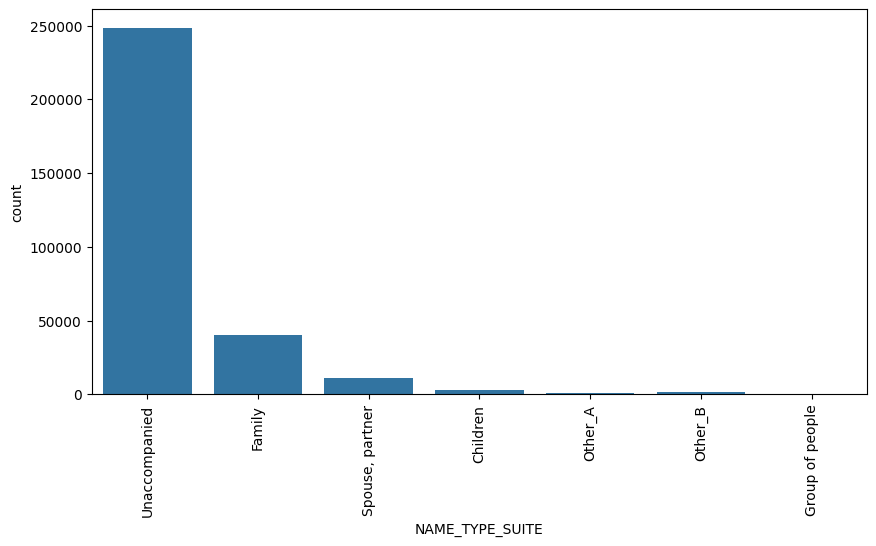

In [73]:
plt.figure(figsize = (10,5))
sns.countplot(data = df, x = "NAME_TYPE_SUITE")
plt.xticks(rotation = 90)
plt.show()

**Спостереження**
-   Дивлячись на графік, категорія `Unaccompanied` має найбільшу кількість заявників на отримання кредиту. Отже, більшість позичальників наважуються звертатися за кредитом без супроводу.
- Ми можемо продовжити і вказати `Unaccompanied` у датафреймі, але я б віддала перевагу другому варіанту.
- Ми також могли заповнити дані зі значенням "NA", оскільки цей стовпець є категоріальним.
- Так само, якщо в стовпці відсутні менше 1% даних, ми можемо видалити відсутні значення. Але якщо ми видалимо всі дані в усіх стовпцях, які мають <=1% відсутніх даних, ми можемо видалити забагато даних. Тому я переважно зберігаю дані, наскільки можу.

In [74]:
#df['NAME_TYPE_SUITE'].fillna('NA', inplace=True)

df.fillna({'NAME_TYPE_SUITE': 'NA'}, inplace = True)

#FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
#The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.
#For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.

### Analysis of `OBS_30_CNT_SOCIAL_CIRCLE` column

In [75]:
null_df_under1[null_df_under1.column_name == 'OBS_30_CNT_SOCIAL_CIRCLE']

,column_name,null_count,null_percentage
91,OBS_30_CNT_SOCIAL_CIRCLE,1021,0.33


In [76]:
df.OBS_30_CNT_SOCIAL_CIRCLE.value_counts().head(10)

OBS_30_CNT_SOCIAL_CIRCLE
0.00    163910
1.00     48783
2.00     29808
3.00     20322
4.00     14143
5.00      9553
6.00      6453
7.00      4390
8.00      2967
9.00      2003
Name: count, dtype: int64

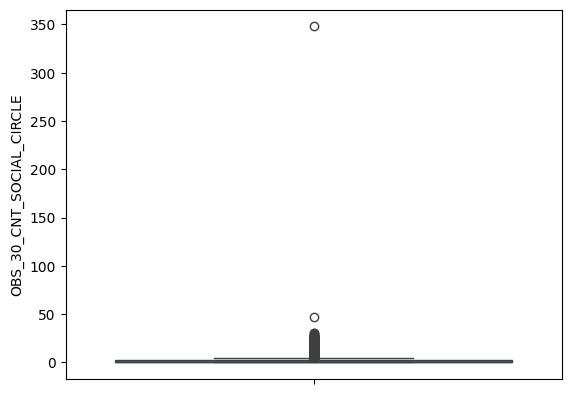

In [77]:
sns.boxplot(df.OBS_30_CNT_SOCIAL_CIRCLE)
plt.show()

Getting percentile values for `OBS_30_CNT_SOCIAL_CIRCLE`

In [78]:
df.OBS_30_CNT_SOCIAL_CIRCLE.quantile(q = [0.25,0.5,0.75,1])

0.25     0.00
0.50     0.00
0.75     2.00
1.00   348.00
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64

Most recurring value in `OBS_30_CNT_SOCIAL_CIRCLE`

In [79]:
df.OBS_30_CNT_SOCIAL_CIRCLE.mode()[0]

0.0

Checking the average value of `OBS_30_CNT_SOCIAL_CIRCLE`

In [80]:
df.OBS_30_CNT_SOCIAL_CIRCLE.mean()

1.4222454239942575

**Спостереження**
- Дивлячись на боксплот, медіана становить 0,0
- Найчастіше повторюване значення становить 0,0
- Середнє значення 1,4222
- Є два виброси: 50 і 350.
- Середнє значення та мода близькі (відносно рангу даних у цьому стовпці) і можуть бути використані для імпутації. Це не призведе до зміщення, оскільки відсоток відсутнього значення невеликий (0,33%)

In [81]:
#df['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(df['OBS_30_CNT_SOCIAL_CIRCLE'].median(), inplace=True)
df.fillna({'OBS_30_CNT_SOCIAL_CIRCLE': df['OBS_30_CNT_SOCIAL_CIRCLE'].median()}, inplace = True)

In [82]:
df.OBS_30_CNT_SOCIAL_CIRCLE.value_counts().head(10)

OBS_30_CNT_SOCIAL_CIRCLE
0.00    164931
1.00     48783
2.00     29808
3.00     20322
4.00     14143
5.00      9553
6.00      6453
7.00      4390
8.00      2967
9.00      2003
Name: count, dtype: int64

# ДЗ 2. Аналіз і заповнення пустих значень у колонках з малим відсотком пропущених

За прикладом вище проведіть аналіз пропущених значень в колонках
- DEF_30_CNT_SOCIAL_CIRCLE
- EXT_SOURCE_2
- OBS_60_CNT_SOCIAL_CIRCLE
- DEF_60_CNT_SOCIAL_CIRCLE
- AMT_GOODS_PRICE

Для швидшого аналізу рекомендую написати фукнцію, яку Ви зможете викликати для кожної з колонок.

Зробіть висновок, що робити з пропущеними значеннями в кожному випадку і виконанайте ту дію, яку зазначили.

## DEF_30_CNT_SOCIAL_CIRCLE

                 column_name  null_count  null_percentage
92  DEF_30_CNT_SOCIAL_CIRCLE        1021             0.33
VALUE COUNTS:
DEF_30_CNT_SOCIAL_CIRCLE
0.00     271324
1.00      28328
2.00       5323
3.00       1192
4.00        253
5.00         56
6.00         11
7.00          1
34.00         1
8.00          1
Name: count, dtype: int64


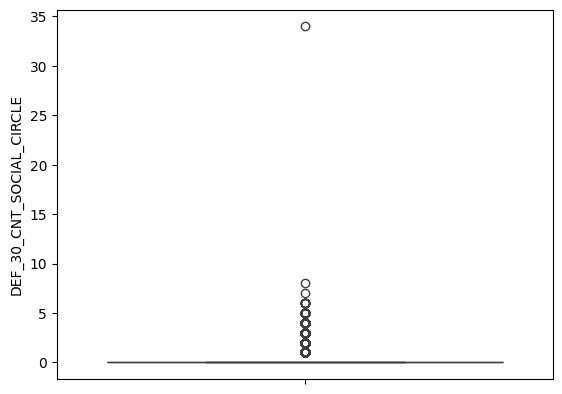

QUANTILE:
0.25    0.00
0.50    0.00
0.75    0.00
1.00   34.00
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float64
MODE: 0.0
MEAN: 0.1434206662533851


In [83]:
hw2_analyse(df, null_df_under1, 'DEF_30_CNT_SOCIAL_CIRCLE')

### **Спостереження**
- Дивлячись на боксплот, медіана становить 0,0
- Найчастіше повторюване значення становить 0,0
- Середнє значення 0.1434
- Є виброси: 6, 7, 34.
- Середнє значення та мода близькі (відносно рангу даних у цьому стовпці) і можуть бути використані для імпутації. Це не призведе до зміщення, оскільки відсоток відсутнього значення невеликий (0,33%)

In [84]:
df.fillna({'DEF_30_CNT_SOCIAL_CIRCLE': df['DEF_30_CNT_SOCIAL_CIRCLE'].median()}, inplace = True)

## EXT_SOURCE_2

hw2_analyse(df, null_df_under1, 'EXT_SOURCE_2')

### **Спостереження**
- Дивлячись на боксплот, медіана становить 0.57
- Найчастіше повторюване значення становить 0.29
- Середнє значення 0.5143
- Немає вибросів
- Середнє значення та медіана близькі (відносно рангу даних у цьому стовпці) і можуть бути використані для імпутації. Це не призведе до зміщення, оскільки відсоток відсутнього значення невеликий (0,21%)

In [85]:
df.fillna({'EXT_SOURCE_2': df['EXT_SOURCE_2'].median()}, inplace = True)

## OBS_60_CNT_SOCIAL_CIRCLE

                 column_name  null_count  null_percentage
93  OBS_60_CNT_SOCIAL_CIRCLE        1021             0.33
VALUE COUNTS:
OBS_60_CNT_SOCIAL_CIRCLE
0.00    164666
1.00     48870
2.00     29766
3.00     20215
4.00     13946
5.00      9463
6.00      6349
7.00      4344
8.00      2886
9.00      1959
Name: count, dtype: int64


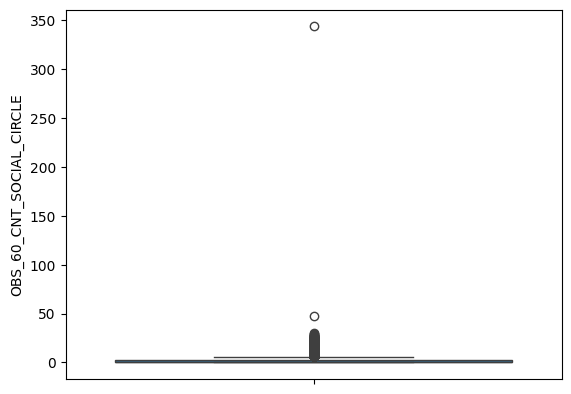

QUANTILE:
0.25     0.00
0.50     0.00
0.75     2.00
1.00   344.00
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float64
MODE: 0.0
MEAN: 1.4052921791901856


In [86]:
hw2_analyse(df, null_df_under1, 'OBS_60_CNT_SOCIAL_CIRCLE')

### **Спостереження**
- Дивлячись на боксплот, медіана становить 0,0
- Найчастіше повторюване значення становить 0,0
- Середнє значення 1.4052
- Є два виброси: 50 і 350.
- Середнє значення, медіана та мода близькі (відносно рангу даних у цьому стовпці) і можуть бути використані для імпутації. Це не призведе до зміщення, оскільки відсоток відсутнього значення невеликий (0,33%)

In [87]:
df.fillna({'OBS_60_CNT_SOCIAL_CIRCLE': df['OBS_60_CNT_SOCIAL_CIRCLE'].median()}, inplace = True)

## DEF_60_CNT_SOCIAL_CIRCLE

                 column_name  null_count  null_percentage
94  DEF_60_CNT_SOCIAL_CIRCLE        1021             0.33
VALUE COUNTS:
DEF_60_CNT_SOCIAL_CIRCLE
0.00     280721
1.00      21841
2.00       3170
3.00        598
4.00        135
5.00         20
6.00          3
7.00          1
24.00         1
Name: count, dtype: int64


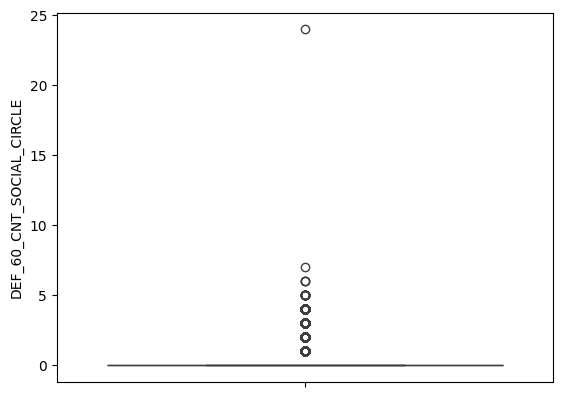

QUANTILE:
0.25    0.00
0.50    0.00
0.75    0.00
1.00   24.00
Name: DEF_60_CNT_SOCIAL_CIRCLE, dtype: float64
MODE: 0.0
MEAN: 0.10004894123788705


In [88]:
hw2_analyse(df, null_df_under1, 'DEF_60_CNT_SOCIAL_CIRCLE')

### **Спостереження**
- Дивлячись на боксплот, медіана становить 0,0
- Найчастіше повторюване значення становить 0,0
- Середнє значення 0.1
- Є виброси: 6, 7, 24.
- Середнє значення, медіана та мода близькі (відносно рангу даних у цьому стовпці) і можуть бути використані для імпутації. Це не призведе до зміщення, оскільки відсоток відсутнього значення невеликий (0,33%)

In [89]:
df.fillna({'DEF_60_CNT_SOCIAL_CIRCLE': df['DEF_60_CNT_SOCIAL_CIRCLE'].mode()[0]}, inplace = True)

## AMT_GOODS_PRICE

        column_name  null_count  null_percentage
10  AMT_GOODS_PRICE         278             0.09
VALUE COUNTS:
AMT_GOODS_PRICE
450000.00     26022
225000.00     25282
675000.00     24962
900000.00     15416
270000.00     11428
180000.00     10123
454500.00      9157
1125000.00     9050
135000.00      8206
315000.00      5225
Name: count, dtype: int64


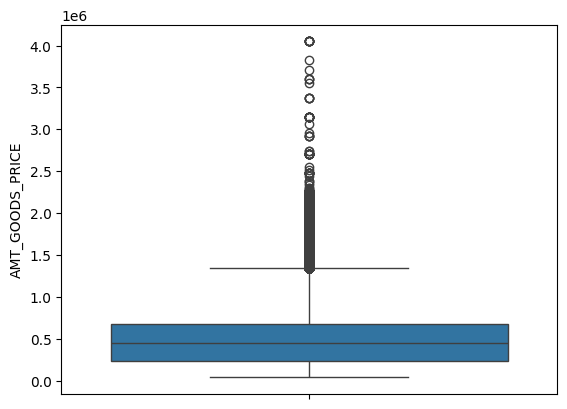

QUANTILE:
0.25    238500.00
0.50    450000.00
0.75    679500.00
1.00   4050000.00
Name: AMT_GOODS_PRICE, dtype: float64
MODE: 450000.0
MEAN: 538396.2074288895


In [90]:
hw2_analyse(df, null_df_under1, 'AMT_GOODS_PRICE')

In [91]:
df.AMT_GOODS_PRICE.quantile(q = [0.25,0.5,0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 1])

0.25    238500.00
0.50    450000.00
0.75    679500.00
0.80    814500.00
0.85    900000.00
0.90   1093500.00
0.95   1305000.00
0.99   1800000.00
1.00   4050000.00
Name: AMT_GOODS_PRICE, dtype: float64

### **Спостереження**
- Дивлячись на боксплот, медіана становить 450000.00
- Найчастіше повторюване значення становить 450000.00
- Середнє значення 538396.2074
- Є виброси: між 3,5 та 4 мільйонами.
- Середнє значення, медіана та мода близькі (відносно рангу даних у цьому стовпці) і можуть бути використані для імпутації. Це не призведе до зміщення, оскільки відсоток відсутнього значення невеликий (0,09%)

In [92]:
df.fillna({'AMT_GOODS_PRICE': df['AMT_GOODS_PRICE'].median()}, inplace = True)

# Робота з неправильними/невідомими значеннями даних

### Аналіз стовпця `CODE_GENDER`

Перевірка діапазону значень

In [93]:
df['CODE_GENDER'].value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

Стать має бути тільки чоловіча або жіноча. Значення `XNA` може вказувати на те, що значення не було надано заявником або пропущено кредитним спеціалістом, який перевіряє заявку

In [94]:
df[df['CODE_GENDER'] == 'XNA']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
35657,141289,0,Revolving loans,XNA,1,1,0,207000.00,382500.00,19125.00,337500.00,Unaccompanied,Working,Secondary / secondary special,Married,Municipal apartment,0.02,-20232,-10044,-10024.00,-3537,1,1,1,1,1,0,Unknown,2.00,3,3,TUESDAY,10,0,0,0,0,0,0,Business Entity Type 1,0.30,0.46,0.00,0.00,0.00,0.00,-286.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
38566,144669,0,Revolving loans,XNA,0,1,2,157500.00,270000.00,13500.00,225000.00,Family,Working,Secondary / secondary special,Married,House / apartment,0.03,-13717,-2797,-2241.00,-4659,1,1,1,1,1,0,Low-skill Laborers,4.00,2,2,FRIDAY,16,0,0,0,0,0,0,Industry: type 3,0.71,0.31,0.00,0.00,0.00,0.00,-493.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,3.00,0.00,4.00
83382,196708,0,Revolving loans,XNA,0,1,1,135000.00,405000.00,20250.00,225000.00,Unaccompanied,Working,Higher education,Married,House / apartment,0.04,-10647,-1228,-183.00,-1671,1,1,1,1,1,0,Core staff,3.00,2,2,THURSDAY,15,0,0,0,0,0,0,Kindergarten,0.66,0.08,7.00,1.00,7.00,1.00,-851.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,3.00
189640,319880,0,Revolving loans,XNA,1,1,0,247500.00,540000.00,27000.00,900000.00,Unaccompanied,Commercial associate,Incomplete higher,Civil marriage,House / apartment,0.04,-9649,-2293,-4099.00,-2326,1,1,1,1,1,0,Unknown,2.00,2,2,FRIDAY,15,0,0,0,0,0,0,Medicine,0.66,0.36,10.00,4.00,10.00,4.00,-1681.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,1.00,6.00


Оскільки дані виглядають достовірними, ми перевіримо можливість застосування методу імпутації.
- Заявників-жінок удвічі більше, ніж заявників-чоловіків
- Отже, ми прирівняємо `CODE_GENDER` до 'F'

In [95]:
df['CODE_GENDER_CHANGED'] = df['CODE_GENDER'].apply(lambda x: 1 if x == 'XNA' else 0)

In [96]:
df['CODE_GENDER'] = df['CODE_GENDER'].apply(lambda x: 'F' if x == 'XNA' else x)

Перевірка, чи вилучено `XNA

In [97]:
df['CODE_GENDER'].value_counts()

CODE_GENDER
F    202452
M    105059
Name: count, dtype: int64

### Аналіз стовпця `DAYS_BIRTH`

In [98]:
df['DAYS_BIRTH'].value_counts().head()

DAYS_BIRTH
-13749    43
-13481    42
-18248    41
-10020    41
-15771    40
Name: count, dtype: int64

Існує ~17K+ унікальних записів, всі з яких, схоже, мають від'ємні значення

In [99]:
df['DAYS_BIRTH'].unique()

array([ -9461, -16765, -19046, ...,  -7951,  -7857, -25061], dtype=int64)

In [100]:
df['DAYS_BIRTH'].nunique()

17460

In [101]:
df['DAYS_BIRTH'].describe()

count   307511.00
mean    -16037.00
std       4363.99
min     -25229.00
25%     -19682.00
50%     -15750.00
75%     -12413.00
max      -7489.00
Name: DAYS_BIRTH, dtype: float64

Перетворення `Days Birth` на додатні дні

In [102]:
df['DAYS_BIRTH'] = df['DAYS_BIRTH'].apply(lambda x: -x if x < 0 else x)

In [103]:
df['DAYS_BIRTH'].describe()

count   307511.00
mean     16037.00
std       4363.99
min       7489.00
25%      12413.00
50%      15750.00
75%      19682.00
max      25229.00
Name: DAYS_BIRTH, dtype: float64

Всі дні в `DAYS_BIRTH` мають додатні значення - це може бути зручніше для аналізу.

#### Створимо нову колонку `YEARS_BIRTH` для зручності аналізу

In [104]:
df['YEARS_BIRTH'] = df['DAYS_BIRTH'].apply(lambda x: round(x/365))

### Аналіз стовпця `NAME_FAMILY_STATUS`

Перевірка діапазону значень

In [105]:
df['NAME_FAMILY_STATUS'].value_counts()

NAME_FAMILY_STATUS
Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: count, dtype: int64

Стать має бути тільки чоловіча або жіноча. Значення `Unknown` може означати, що значення не було вказане заявником або пропущене кредитним спеціалістом, який перевіряє заявку

In [106]:
df[df['NAME_FAMILY_STATUS'] == 'Unknown']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_CHANGED,YEARS_BIRTH
41982,148605,0,Revolving loans,M,0,1,0,450000.00,675000.00,33750.00,450000.00,NA,Commercial associate,Lower secondary,Unknown,Municipal apartment,0.02,12396,-1161,-3265.00,-4489,1,1,1,1,1,0,Managers,NaN,2,2,THURSDAY,15,0,1,1,0,1,1,Insurance,0.70,NaN,3.00,0.00,3.00,0.00,-876.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,34
187348,317181,0,Revolving loans,F,0,1,0,202500.00,585000.00,29250.00,450000.00,NA,Commercial associate,Higher education,Unknown,House / apartment,0.03,12844,-232,-1597.00,-1571,1,1,0,1,0,0,Accountants,NaN,2,2,FRIDAY,14,0,0,0,0,0,0,Business Entity Type 2,0.65,0.67,1.00,0.00,1.00,0.00,-654.00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00,0,35


In [107]:
df['NAME_FAMILY_STATUS'].value_counts(normalize = True) * 100

NAME_FAMILY_STATUS
Married                63.88
Single / not married   14.78
Civil marriage          9.68
Separated               6.43
Widow                   5.23
Unknown                 0.00
Name: proportion, dtype: float64

Оскільки дані виглядають достовірними, ми продовжимо перевірку методу імплікації.
- Одружені заявники складають понад 63% заявників.
- Отже, ми прирівняємо `NAME_FAMILY_STATUS` до `Married`.

In [108]:
df['NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].apply(lambda x: 'Married' if x == 'Unknown' else x)

Перевірка чи вилучено `Unknown`

In [109]:
df['NAME_FAMILY_STATUS'].value_counts()

NAME_FAMILY_STATUS
Married                 196434
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Name: count, dtype: int64

### Аналіз стовпця`DAYS_EMPLOYED`

In [110]:
df['DAYS_EMPLOYED'].value_counts().head()

DAYS_EMPLOYED
 365243    55374
-200         156
-224         152
-230         151
-199         151
Name: count, dtype: int64

In [111]:
df['DAYS_EMPLOYED'].value_counts(normalize = True) * 100

DAYS_EMPLOYED
 365243   18.01
-200       0.05
-224       0.05
-230       0.05
-199       0.05
           ... 
-13961     0.00
-11827     0.00
-10176     0.00
-9459      0.00
-8694      0.00
Name: proportion, Length: 12574, dtype: float64

In [112]:
len(df[df['DAYS_EMPLOYED'] < 365243])

252137

In [113]:
df[df['DAYS_EMPLOYED'] < 365243].DAYS_EMPLOYED.value_counts()

DAYS_EMPLOYED
-200      156
-224      152
-199      151
-230      151
-212      150
         ... 
-13961      1
-11827      1
-10176      1
-9459       1
-8694       1
Name: count, Length: 12573, dtype: int64

In [114]:
df['DAYS_EMPLOYED'].unique()

array([  -637,  -1188,   -225, ..., -12971, -11084,  -8694], dtype=int64)

In [115]:
df['DAYS_EMPLOYED'].nunique()

12574

**Спостереження**
- Існує ~55K+ записів, для яких `DAYS_EMPLOYED` дорівнює 365243 дням
- Решта 252K+ записів мають від'ємне значення днів
- Існує 12 574 унікальних значень для `DAYS_EMPLOYED

 - Колонка `DAYS_EMPLOYED` вказує на те, за скільки днів до подачі заявки особа почала поточну роботу, заявник/кредитний спеціаліст повинен ввести від'ємні значення, щоб вказати дні, що передують даті подачі заявки.<br>
 - Ми конвертуємо від'ємні значення в `DAYS_EMPLOYED` в додатні дні, щоб стандартизувати дні під час використання в розрахунках

In [116]:
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: -x if x < 0 else x)

In [117]:
df['DAYS_EMPLOYED'].value_counts().head()

DAYS_EMPLOYED
365243    55374
200         156
224         152
230         151
199         151
Name: count, dtype: int64

Ми бачимо, що всі дні в `DAYS_EMPLOYED` мають додатні значення.

**Для ~55K+ записів, для яких `DAYS_EMPLOYED` становить 365243 дні**
- Конвертуючи це в роки, ми отримуємо 1000 років, які фізично неможливо використати для працевлаштування заявника
- Це відповідає 18% даних і не може бути аномалією
- Вони можуть бути або "пенсіонерами", або "безробітними", і, дивлячись на дані, наш висновок є правильним

> Є два способи впоратися з цим
>> 1) Ми залишаємо дані такими, якими вони є, і враховуємо це під час аналізу АБО  <br>
>> 2) Ми розраховуємо середню кількість днів зайнятості без урахування цієї категорії та вписуємо її замість 365243 днів для пенсіонерів. <br>
>> Для безробітних кількість днів зайнятості може дорівнювати 0

*Примітка*
 - Під час розрахунків у цьому стовпчику ми повинні враховувати цей сценарій, оскільки інакше він спотворює наші результати

In [118]:
days_median = df[df['DAYS_EMPLOYED'] != 365243].DAYS_EMPLOYED.median()

In [119]:
df_days_employed = df['DAYS_EMPLOYED'].apply(lambda x: days_median if x==365243 else x)

<Axes: >

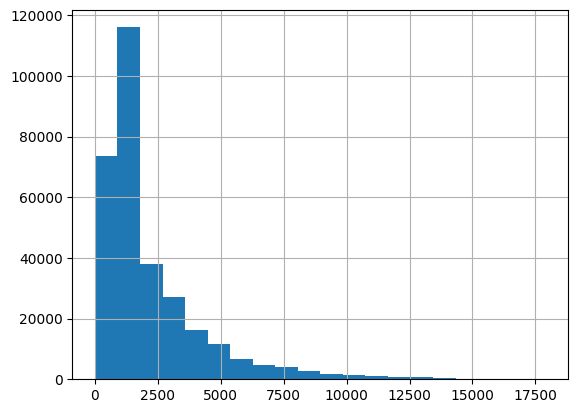

In [120]:
df_days_employed.hist(bins=20)

<Axes: >

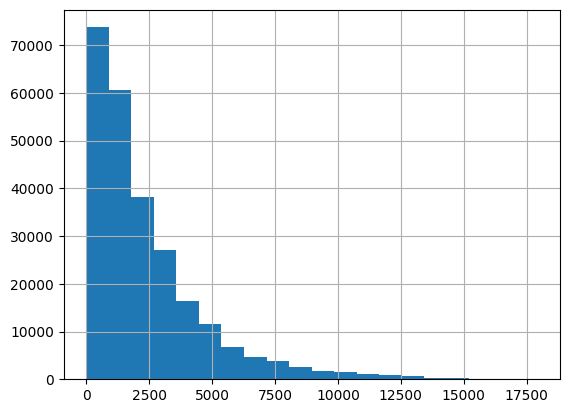

In [121]:
df[df['DAYS_EMPLOYED'] != 365243].DAYS_EMPLOYED.hist(bins=20)

In [122]:
df[df['DAYS_EMPLOYED'] == 365243].NAME_INCOME_TYPE.value_counts()

NAME_INCOME_TYPE
Pensioner     55352
Unemployed       22
Name: count, dtype: int64

#### Створимо нову колонку `YEARS_EMPLOYED` для зручності аналізу

In [123]:
df['YEARS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: round(x/365))

### Аналіз стовпця `DAYS_REGISTRATION`

In [124]:
df['DAYS_REGISTRATION'].value_counts().head()

DAYS_REGISTRATION
-1.00    113
-7.00     98
-6.00     96
-4.00     92
-2.00     92
Name: count, dtype: int64

In [125]:
df['DAYS_REGISTRATION'].value_counts(normalize = True).head()

DAYS_REGISTRATION
-1.00   0.00
-7.00   0.00
-6.00   0.00
-4.00   0.00
-2.00   0.00
Name: proportion, dtype: float64

In [126]:
df['DAYS_REGISTRATION'].unique()

array([ -3648.,  -1186.,  -4260., ..., -16396., -14558., -14798.])

In [127]:
df['DAYS_REGISTRATION'].nunique()

15688

Перетворення `DAYS_REGISTRATION` в додатні дні

In [128]:
df['DAYS_REGISTRATION'] = df['DAYS_REGISTRATION'].apply(lambda x: -x if x < 0 else x)

In [129]:
df['DAYS_REGISTRATION'].value_counts().head()

DAYS_REGISTRATION
1.00    113
7.00     98
6.00     96
4.00     92
2.00     92
Name: count, dtype: int64

Всі дні в `DAYS_REGISTRATION` мають додатні значення

#### Створимо нову колонку `YEARS_REGISTRATION` для зручності аналізу

In [130]:
df['YEARS_REGISTRATION'] = df['DAYS_REGISTRATION'].apply(lambda x: round(x/365))

### Аналіз стовпця `DAYS_ID_PUBLISH`

In [131]:
df['DAYS_ID_PUBLISH'].value_counts().head()

DAYS_ID_PUBLISH
-4053    169
-4095    162
-4046    161
-4417    159
-4256    158
Name: count, dtype: int64

In [132]:
df['DAYS_ID_PUBLISH'].value_counts(normalize = True).head()

DAYS_ID_PUBLISH
-4053   0.00
-4095   0.00
-4046   0.00
-4417   0.00
-4256   0.00
Name: proportion, dtype: float64

In [133]:
df['DAYS_ID_PUBLISH'].unique()

array([-2120,  -291, -2531, ..., -6194, -5854, -6211], dtype=int64)

In [134]:
df['DAYS_ID_PUBLISH'].nunique()

6168

Перетворення `DAYS_ID_PUBLISH` в додатні дні

In [135]:
df['DAYS_ID_PUBLISH'] = df['DAYS_ID_PUBLISH'].apply(lambda x: -x if x < 0 else x)

In [136]:
df['DAYS_ID_PUBLISH'].value_counts().head()

DAYS_ID_PUBLISH
4053    169
4095    162
4046    161
4417    159
4256    158
Name: count, dtype: int64

Всі дні в `DAYS_ID_PUBLISH` мають додатні значення

#### Створимо нову колонку `YEARS_ID_PUBLISH` для зручності аналізу

In [137]:
df['YEARS_ID_PUBLISH'] = df['DAYS_ID_PUBLISH'].apply(lambda x: round(x/365))

### Аналіз стовпця `DAYS_LAST_PHONE_CHANGE`

In [138]:
df['DAYS_LAST_PHONE_CHANGE'].value_counts().head()

DAYS_LAST_PHONE_CHANGE
0.00     37672
-1.00     2812
-2.00     2318
-3.00     1763
-4.00     1285
Name: count, dtype: int64

In [139]:
df['DAYS_LAST_PHONE_CHANGE'].value_counts(normalize = True).head()

DAYS_LAST_PHONE_CHANGE
0.00    0.12
-1.00   0.01
-2.00   0.01
-3.00   0.01
-4.00   0.00
Name: proportion, dtype: float64

In [140]:
df['DAYS_LAST_PHONE_CHANGE'].unique()

array([-1134.,  -828.,  -815., ..., -3988., -3899., -3538.])

In [141]:
df['DAYS_LAST_PHONE_CHANGE'].nunique()

3773

Перетворення `DAYS_LAST_PHONE_CHANGE` в додатні дні

In [142]:
df['DAYS_LAST_PHONE_CHANGE'] = df['DAYS_LAST_PHONE_CHANGE'].apply(lambda x: -x if x < 0 else x)

In [143]:
df['DAYS_LAST_PHONE_CHANGE'].value_counts().head()

DAYS_LAST_PHONE_CHANGE
0.00    37672
1.00     2812
2.00     2318
3.00     1763
4.00     1285
Name: count, dtype: int64

Всі дні в `DAYS_LAST_PHONE_CHANGE` мають додатні значення

#### Створення нової колонки `YEARS_LAST_PHONE_CHANGE` для зручності аналізу

In [144]:
df['YEARS_LAST_PHONE_CHANGE'] = df['DAYS_LAST_PHONE_CHANGE'].apply(lambda x: round(x/365,0))

# Функції для автоматизації

### Створення функції `age_cat` для категоризації даних, що містять інформацію про роки

In [145]:
def age_cat(years):
    if years <= 20:
        return '0-20'
    elif years > 20 and years <= 30:
        return '20-30'
    elif years > 30 and years <= 40:
        return '30-40'
    elif years > 40 and years <= 50:
        return '40-50'
    elif years > 50 and years <= 60:
        return '50-60'
    elif years > 60 and years <= 70:
        return '60-70'
    elif years > 70:
        return '70+'

### Одномірний (категоріальний vs цільовий) та двомірний (категоріальний vs категоріальний) аналіз (гістограма) - категоріальні стовпчики

In [146]:
import matplotlib.pyplot as plt


def bi_cat_countplot(df, column, hue_column):
    unique_hue_values = df[hue_column].unique()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(14,6)

    pltname = f'Нормалізований розподіл значень за категорією: {column}'
    proportions = df.groupby(hue_column)[column].value_counts(normalize=True)
    proportions = (proportions*100).round(2)
    ax = proportions.unstack(hue_column).sort_values(
        by=unique_hue_values[0], ascending=False
        ).plot.bar(ax=axes[0], title=pltname)

    # анотація значень в барплоті
    for container in ax.containers:
        ax.bar_label(container, fmt='{:,.1f}%')

    pltname = f'Кількість даних за категорією: {column}'
    counts = df.groupby(hue_column)[column].value_counts()
    ax = counts.unstack(hue_column).sort_values(
        by=unique_hue_values[0], ascending=False
        ).plot.bar(ax=axes[1], title=pltname)

    for container in ax.containers:
      ax.bar_label(container)


def uni_cat_target_compare(df, column):
    bi_cat_countplot(df, column, hue_column='TARGET')


### Обчислення мінімального та максимального діапазону відхилень для числових стовпців

In [147]:
def outlier_range(dataset,column):
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1
    Min_value = (Q1 - 1.5 * IQR)
    Max_value = (Q3 + 1.5 * IQR)
    return Max_value

### Робота з викидами для числових стовпців

In [148]:
import warnings

def dist_box(dataset, column):
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")

      plt.figure(figsize=(16,6))

      plt.subplot(1,2,1)
      sns.distplot(dataset[column], color = 'purple')
      pltname = 'Графік розподілу для ' + column
      plt.ticklabel_format(style='plain', axis='x')
      plt.title(pltname)

      plt.subplot(1,2,2)
      red_diamond = dict(markerfacecolor='r', marker='D')
      sns.boxplot(y = column, data = dataset, flierprops = red_diamond)
      pltname = 'Боксплот для ' + column
      plt.title(pltname)

      plt.show()

### Аналіз стовпця`CNT_CHILDREN`

In [149]:
df['CNT_CHILDREN'].value_counts().sort_values(ascending = False);

In [150]:
(df['CNT_CHILDREN'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

CNT_CHILDREN
0   70.04
1   19.88
2    8.70
3    1.21
4    0.14
Name: proportion, dtype: float64

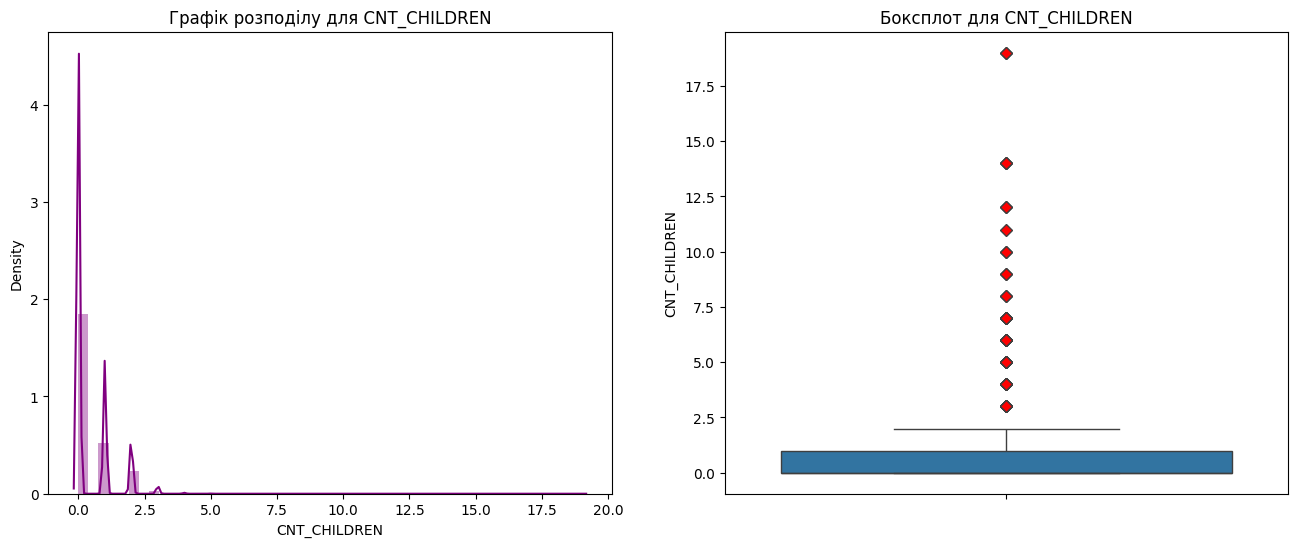

In [151]:
dist_box(df,'CNT_CHILDREN')

Розрахуємо IQR (Inter Quartile range)

In [152]:
Q1 = df['CNT_CHILDREN'].quantile(0.25)
Q3 = df['CNT_CHILDREN'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

1.0


In [153]:
Q1, Q3

(0.0, 1.0)

Значення *до* (Q1 - 1,5 * IQR) та *після* (Q3 + 1,5 * IQR) є викидами

In [154]:
Min_value = (Q1 - 1.5 * IQR)
Max_value = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value))

Мінімальне значення, до якого існують викиди: -1.5
Максимальне значення, після якого існують викиди: 2.5


In [155]:
df[df['CNT_CHILDREN'].isin(range(10,20))].YEARS_BIRTH

34545     47
80948     39
132585    31
155369    30
171125    38
176011    49
183878    56
186820    41
265784    28
267998    42
Name: YEARS_BIRTH, dtype: int64

In [156]:
df[df['CNT_CHILDREN'].isin([10])][['SK_ID_CURR', 'CNT_CHILDREN', 'YEARS_BIRTH']]

,SK_ID_CURR,CNT_CHILDREN,YEARS_BIRTH
132585,253779,10,31
186820,316580,10,41


**Спостереження**
- Дивлячись на дані, ми бачимо, що кількість заявників, які мають більше 7 дітей, є дуже мінімальною (2 або 3 в кожній категорії)
- Крім того, дивлячись на дані для заявників з 10 дітьми, заявники мають лише 31 й 41 рік відповідно. Це виглядає як одиничний випадок й може розглядатися як відхилення від норми
- Як дистрибутивні, так і діаграми розмаху чітко показують, що значення, які перевищують значення 2.5, є відхиленнями від норми.

**Висновок**
- Заявники, які мають 3 або більше дітей, є випадками, що відхиляються від норми. Ми можемо надати спеціальний аналіз для цих випадків.

### Аналіз стовпця `AMT_INCOME_TOTAL`

In [157]:
df['AMT_INCOME_TOTAL'].value_counts().sort_values(ascending = False).head()

AMT_INCOME_TOTAL
135000.00    35750
112500.00    31019
157500.00    26556
180000.00    24719
90000.00     22483
Name: count, dtype: int64

In [158]:
(df['AMT_INCOME_TOTAL'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

AMT_INCOME_TOTAL
135000.00   11.63
112500.00   10.09
157500.00    8.64
180000.00    8.04
90000.00     7.31
Name: proportion, dtype: float64

In [159]:
df['AMT_INCOME_TOTAL'].describe(percentiles = [0.75,0.99,0.999])

count      307511.00
mean       168797.92
std        237123.15
min         25650.00
50%        147150.00
75%        202500.00
99%        472500.00
99.9%      900000.00
max     117000000.00
Name: AMT_INCOME_TOTAL, dtype: float64

Побудуємо графік для `AMT_INCOME_TOTAL`

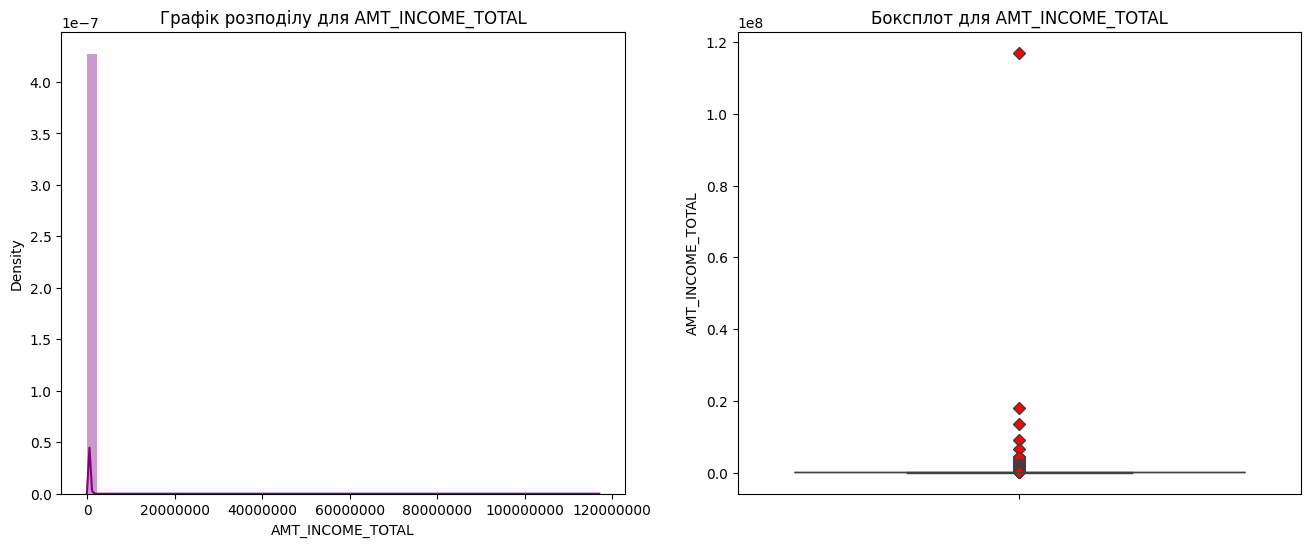

In [160]:
dist_box(df,'AMT_INCOME_TOTAL')

- Графіки кінцевого результату дуже тонкі, й ми можемо спостерігати викид близько ~120 мільйонів.
- Давайте побудуємо графік, розглядаючи лише дохід нижче 99,9% значення, тобто 900 тисяч.

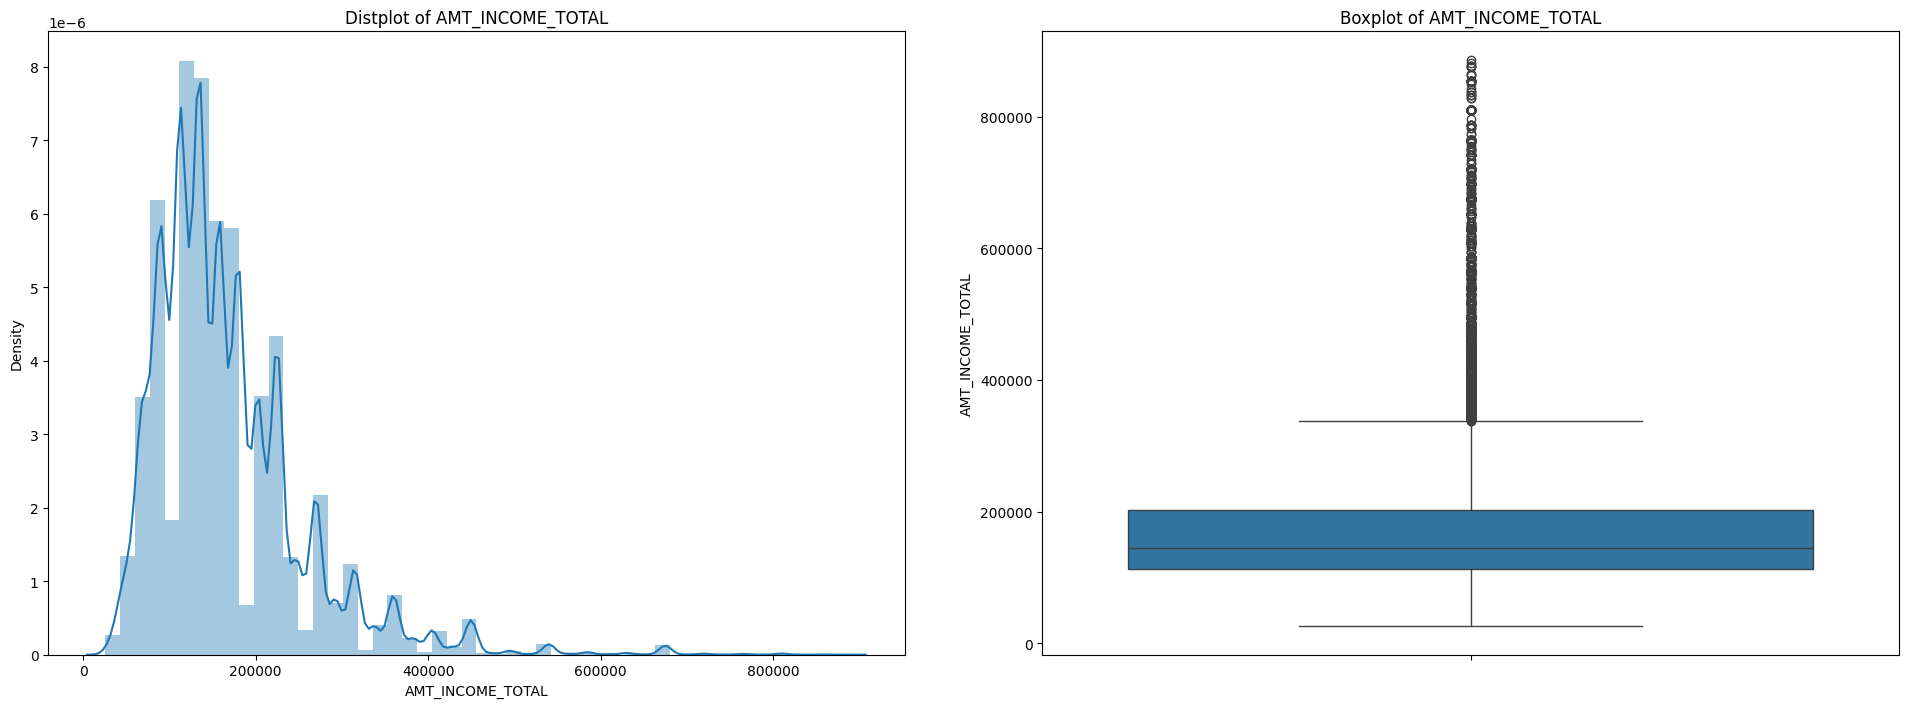

In [161]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.subplots(1,2 ,figsize = (20,8))

    plt.subplot(121)
    sns.distplot(df[df['AMT_INCOME_TOTAL'] < 900000].AMT_INCOME_TOTAL)
    pltname = 'Distplot of ' + 'AMT_INCOME_TOTAL'
    plt.title(pltname)

    plt.subplot(122)
    sns.boxplot(df[df['AMT_INCOME_TOTAL'] < 900000].AMT_INCOME_TOTAL)
    pltname = 'Boxplot of ' + 'AMT_INCOME_TOTAL'
    plt.title(pltname)

    plt.tight_layout(pad = 4)
    plt.show()

Тепер ми можемо чітко побачити розподіл і діапазон даних на обох графіках.
 - Це означає, що значення понад 900 тис. грн доходу явно є викидами

In [162]:
df[df['AMT_INCOME_TOTAL'] > 900000].head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_CHANGED,YEARS_BIRTH,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,YEARS_LAST_PHONE_CHANGE
1504,101769,0,Revolving loans,M,1,1,0,1080000.00,180000.00,9000.00,180000.00,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.07,13633,5536,3.00,4971,1,1,0,1,0,0,Unknown,2.00,1,1,FRIDAY,13,0,1,1,0,0,0,Business Entity Type 3,0.65,0.46,0.00,0.00,0.00,0.00,491.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,37,15,0,14,1.00
1723,102015,0,Cash loans,F,0,1,0,1935000.00,269550.00,10534.50,225000.00,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.01,18636,365243,3401.00,2168,1,0,0,1,1,0,Unknown,2.00,2,2,MONDAY,11,0,0,0,0,0,0,XNA,0.27,0.33,1.00,0.00,1.00,0.00,381.00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,51,1001,9,6,1.00
3371,103938,0,Cash loans,F,0,0,1,1350000.00,2410380.00,109053.00,2250000.00,NA,Commercial associate,Higher education,Married,House / apartment,0.07,12213,843,757.00,4132,1,1,0,1,1,0,Managers,3.00,1,1,SUNDAY,13,0,1,1,0,0,0,Housing,0.72,0.57,0.00,0.00,0.00,0.00,2.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.00,0.00,0.00,3.00,0.00,0.00,0,33,2,2,11,0.00
4603,105384,0,Revolving loans,F,1,1,0,1350000.00,405000.00,20250.00,405000.00,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.02,14781,4768,3469.00,4045,1,1,0,1,0,0,Managers,2.00,2,2,TUESDAY,12,0,0,0,0,0,0,Business Entity Type 3,0.66,0.73,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0,40,13,10,11,0.00
5673,106637,0,Cash loans,M,1,1,3,967500.00,450000.00,30073.50,450000.00,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.05,11901,546,2932.00,215,1,1,0,1,0,0,Managers,5.00,1,1,MONDAY,14,0,0,0,1,1,0,Business Entity Type 3,0.49,0.45,0.00,0.00,0.00,0.00,88.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,1.00,1.00,0.00,0,33,1,8,1,0.00


**Спостереження**
- Дивлячись на дані, ми бачимо, що дохід понад 900 тис. грн (99,9% значення) є викидом
- Як діаграма розподілу, так і діаграма розмаху чітко показують нам ту саму тенденцію

**Висновок**
- Апліканти з доходом понад 900 тис. грн (99,9% значення) є викидами

# ДЗ 3. Аналіз викидів

Подібно до прикладу, проаналізуйте на викиди колонок
- `CNT_FAM_MEMBERS`
- `AMT_ANNUITY`

Зазначте, які значення в них можна вважати викидами.

### Аналіз стовпця `CNT_FAM_MEMBERS`

In [163]:
df['CNT_FAM_MEMBERS'].value_counts().sort_values(ascending = False).head()

CNT_FAM_MEMBERS
2.00    158357
1.00     67847
3.00     52601
4.00     24697
5.00      3478
Name: count, dtype: int64

In [164]:
df['CNT_FAM_MEMBERS'].describe(percentiles = [0.75,0.99,0.999])

count   307509.00
mean         2.15
std          0.91
min          1.00
50%          2.00
75%          3.00
99%          5.00
99.9%        6.00
max         20.00
Name: CNT_FAM_MEMBERS, dtype: float64

In [165]:
df[df['CNT_FAM_MEMBERS'] > 6][['CNT_FAM_MEMBERS', 'CNT_CHILDREN']].head(10)

,CNT_FAM_MEMBERS,CNT_CHILDREN
3079,9.00,7
3448,7.00,5
7204,8.00,6
8254,7.00,5
9712,7.00,5
9793,7.00,5
12615,10.00,8
17516,8.00,6
17640,7.00,5
21101,7.00,5


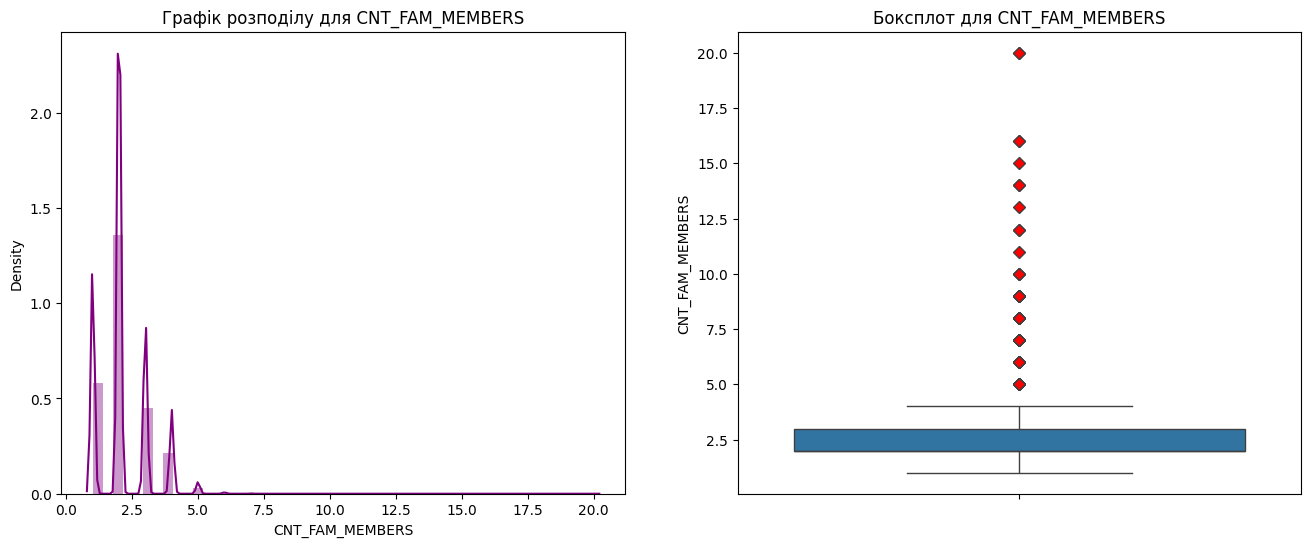

In [166]:
dist_box(df,'CNT_FAM_MEMBERS')

In [167]:
(df['CNT_FAM_MEMBERS'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

CNT_FAM_MEMBERS
2.00   51.50
1.00   22.06
3.00   17.11
4.00    8.03
5.00    1.13
Name: proportion, dtype: float64

In [168]:
CNT_FAM_MEMBERS_Q1 = df['CNT_FAM_MEMBERS'].quantile(0.25)
CNT_FAM_MEMBERS_Q3 = df['CNT_FAM_MEMBERS'].quantile(0.75)
CNT_FAM_MEMBERS_IQR = CNT_FAM_MEMBERS_Q3 - CNT_FAM_MEMBERS_Q1
CNT_FAM_MEMBERS_Min_value = (CNT_FAM_MEMBERS_Q1 - 1.5 * CNT_FAM_MEMBERS_IQR)
CNT_FAM_MEMBERS_Max_value = (CNT_FAM_MEMBERS_Q3 + 1.5 * CNT_FAM_MEMBERS_IQR)

print("Inter Quartile range: {}".format(CNT_FAM_MEMBERS_IQR))
print("Мінімальне значення, до якого існують викиди: {}".format(CNT_FAM_MEMBERS_Min_value))
print("Максимальне значення, після якого існують викиди: {}".format(CNT_FAM_MEMBERS_Max_value))

Inter Quartile range: 1.0
Мінімальне значення, до якого існують викиди: 0.5
Максимальне значення, після якого існують викиди: 4.5


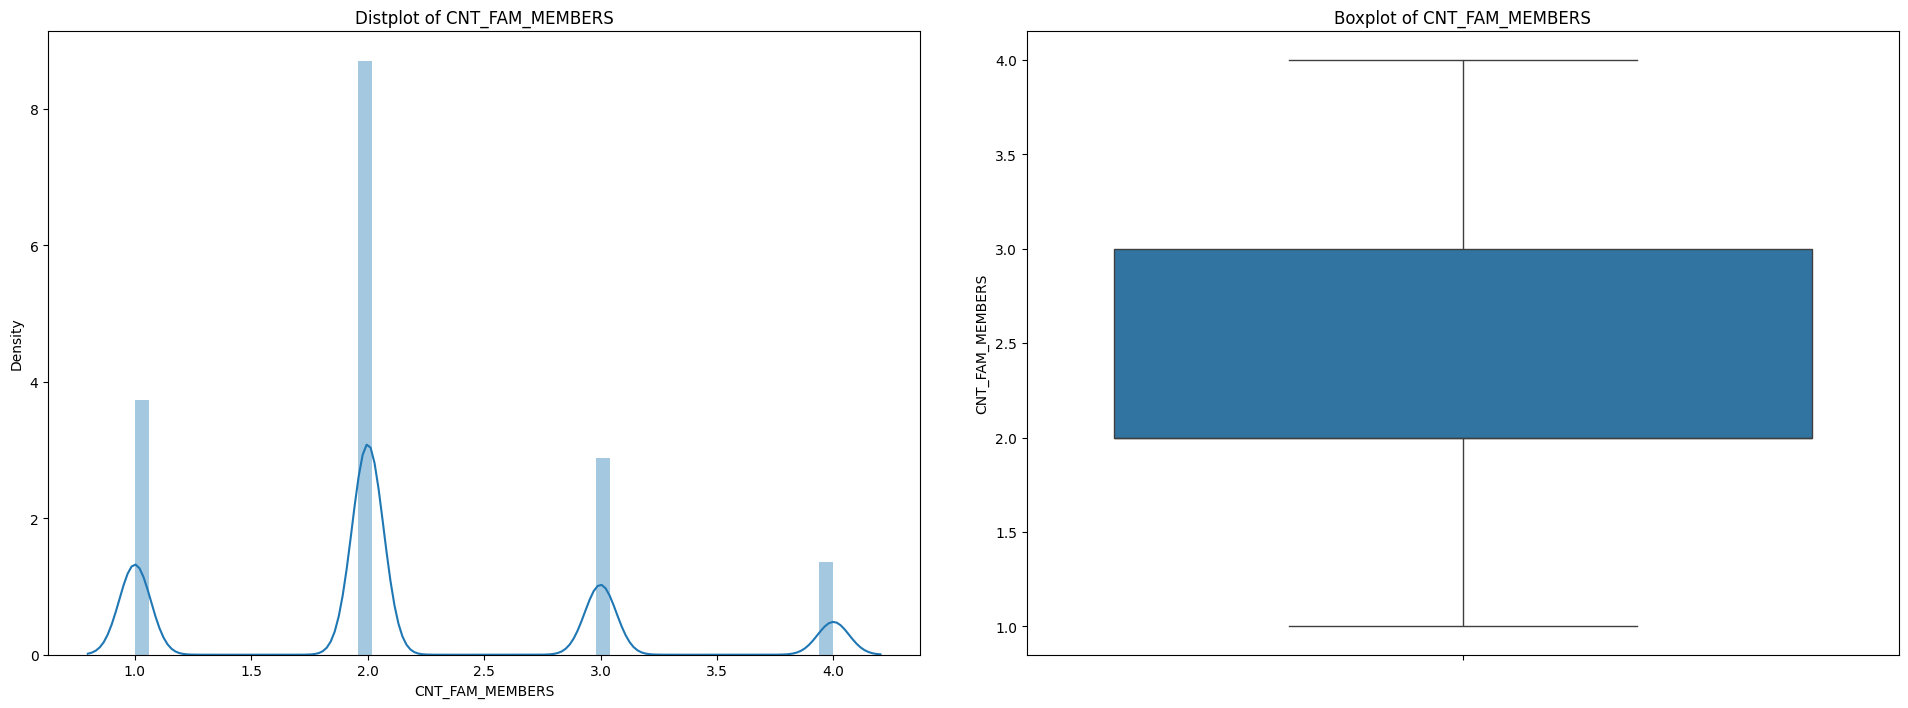

In [169]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.subplots(1,2 ,figsize = (20,8))

    plt.subplot(121)
    sns.distplot(df[df['CNT_FAM_MEMBERS'] < 5].CNT_FAM_MEMBERS)
    pltname = 'Distplot of CNT_FAM_MEMBERS'
    plt.title(pltname)

    plt.subplot(122)
    sns.boxplot(df[df['CNT_FAM_MEMBERS'] < 5].CNT_FAM_MEMBERS)
    pltname = 'Boxplot of CNT_FAM_MEMBERS'
    plt.title(pltname)

    plt.tight_layout(pad = 4)
    plt.show()

#### Спостереження
- Дивлячись на дані, ми бачимо, що кількість заявників, які мають більше 5 членів сім'ї, є дуже мінімальною 
- Як дистрибутивні, так і діаграми розмаху чітко показують, що значення, які перевищують значення 4.5, є відхиленнями від норми.
- 5 і більше членів сім'ї та 3 і більше дитини (колонка CNT_CHILDREN) є відхиленням від норми.


#### Висновок
- Заявники, які мають 5 або більше членів сім'ї, є випадками, що відхиляються від норми. Ми можемо надати спеціальний аналіз для цих випадків.

### Аналіз стовпця `AMT_ANNUITY`

In [170]:
(df['AMT_ANNUITY'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

AMT_ANNUITY
9000.00    2.08
13500.00   1.79
6750.00    0.74
10125.00   0.66
37800.00   0.52
Name: proportion, dtype: float64

In [171]:
df['AMT_ANNUITY'].describe(percentiles = [0.75,0.85,0.97,0.98,0.99,0.999])

count   307499.00
mean     27108.57
std      14493.74
min       1615.50
50%      24903.00
75%      34596.00
85%      40806.00
97%      58482.00
98%      62964.00
99%      70006.50
99.9%   110047.50
max     258025.50
Name: AMT_ANNUITY, dtype: float64

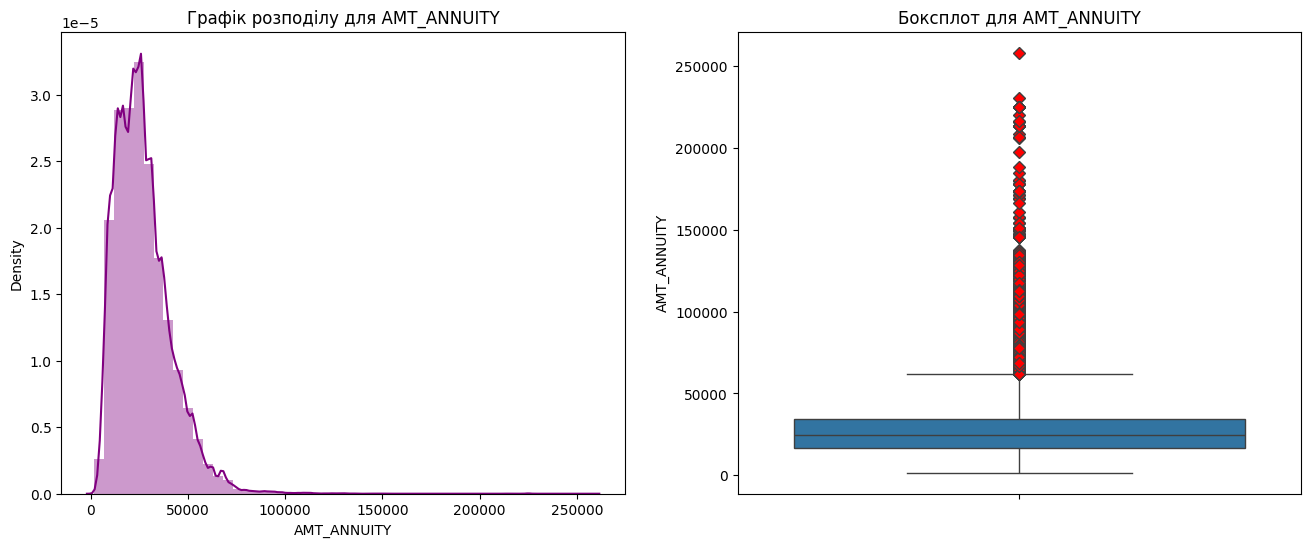

In [172]:
dist_box(df,'AMT_ANNUITY')

In [173]:
AMT_ANNUITY_Q1 = df['AMT_ANNUITY'].quantile(0.25)
AMT_ANNUITY_Q3 = df['AMT_ANNUITY'].quantile(0.75)
AMT_ANNUITY_IQR = AMT_ANNUITY_Q3 - AMT_ANNUITY_Q1
AMT_ANNUITY_Min_value = (AMT_ANNUITY_Q1 - 1.5 * AMT_ANNUITY_IQR)
AMT_ANNUITY_Max_value = (AMT_ANNUITY_Q3 + 1.5 * AMT_ANNUITY_IQR)

print("Inter Quartile range: {}".format(AMT_ANNUITY_IQR))
print("Мінімальне значення, до якого існують викиди: {}".format(AMT_ANNUITY_Min_value))
print("Максимальне значення, після якого існують викиди: {}".format(AMT_ANNUITY_Max_value))

Inter Quartile range: 18072.0
Мінімальне значення, до якого існують викиди: -10584.0
Максимальне значення, після якого існують викиди: 61704.0


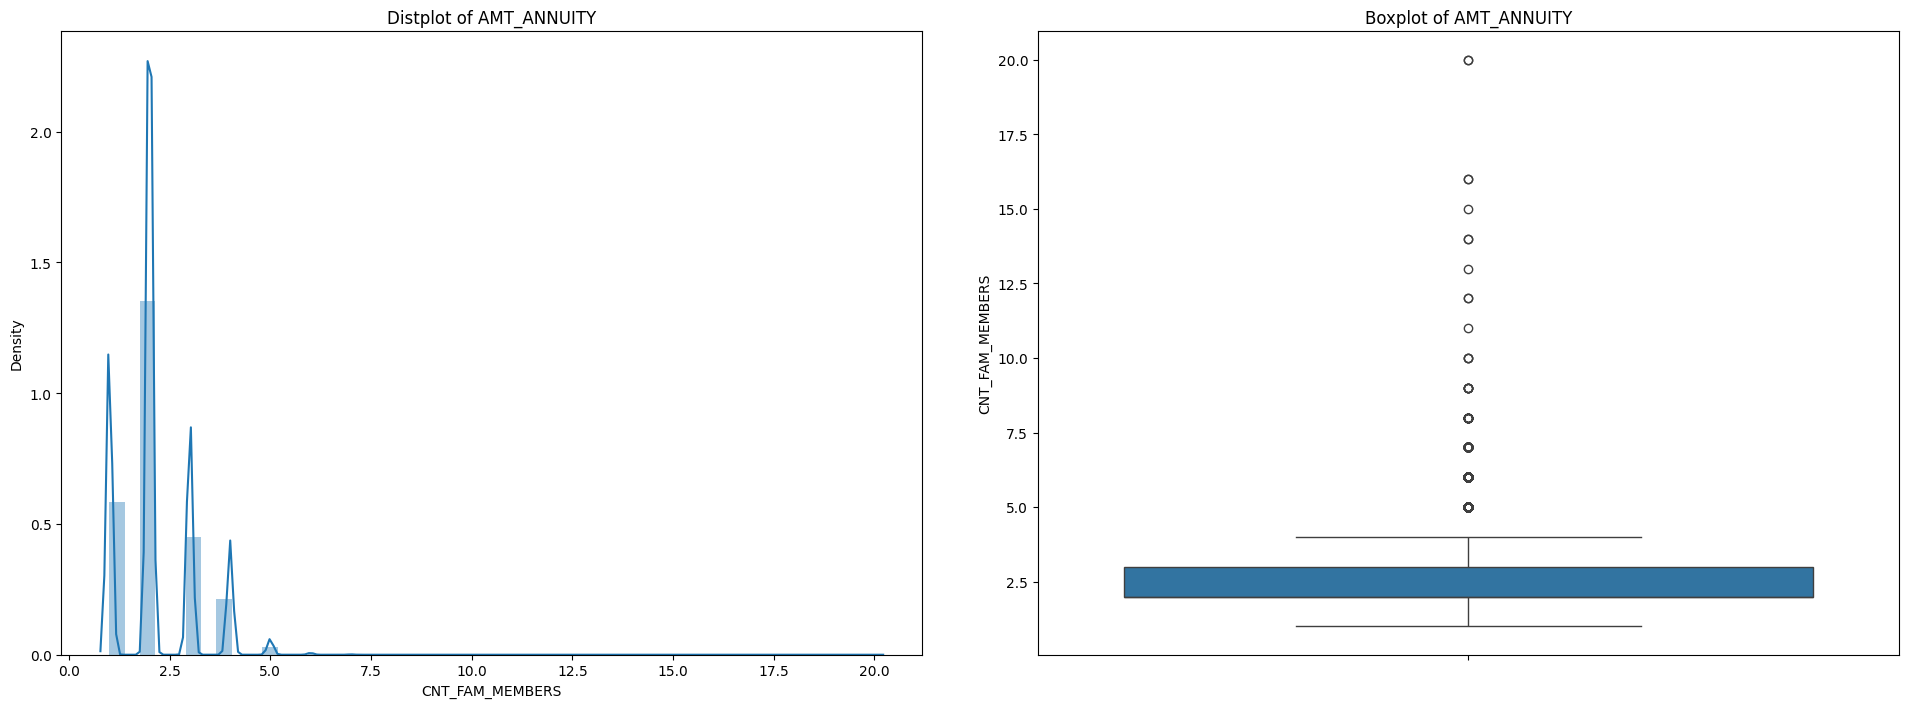

In [174]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.subplots(1,2 ,figsize = (20,8))

    plt.subplot(121)
    sns.distplot(df[df['AMT_ANNUITY'] < 61704.0].CNT_FAM_MEMBERS)
    pltname = 'Distplot of AMT_ANNUITY'
    plt.title(pltname)

    plt.subplot(122)
    sns.boxplot(df[df['AMT_ANNUITY'] < 61704.0].CNT_FAM_MEMBERS)
    pltname = 'Boxplot of AMT_ANNUITY'
    plt.title(pltname)

    plt.tight_layout(pad = 4)
    plt.show()

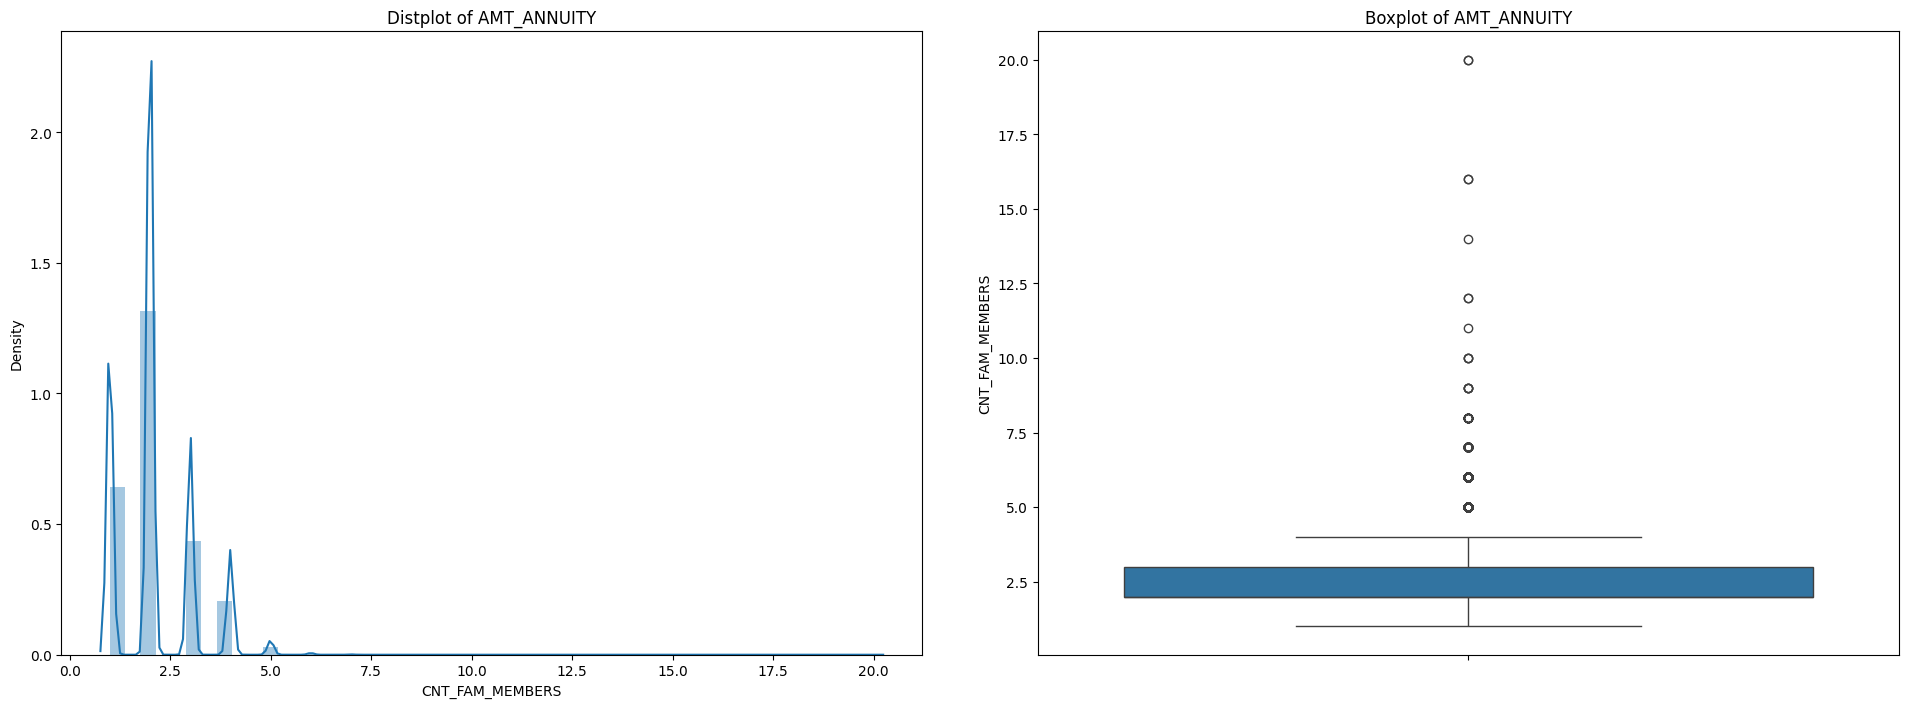

In [175]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.subplots(1,2 ,figsize = (20,8))

    plt.subplot(121)
    sns.distplot(df[df['AMT_ANNUITY'] < 34596.0].CNT_FAM_MEMBERS)
    pltname = 'Distplot of AMT_ANNUITY'
    plt.title(pltname)

    plt.subplot(122)
    sns.boxplot(df[df['AMT_ANNUITY'] < 34596.0].CNT_FAM_MEMBERS)
    pltname = 'Boxplot of AMT_ANNUITY'
    plt.title(pltname)

    plt.tight_layout(pad = 4)
    plt.show()

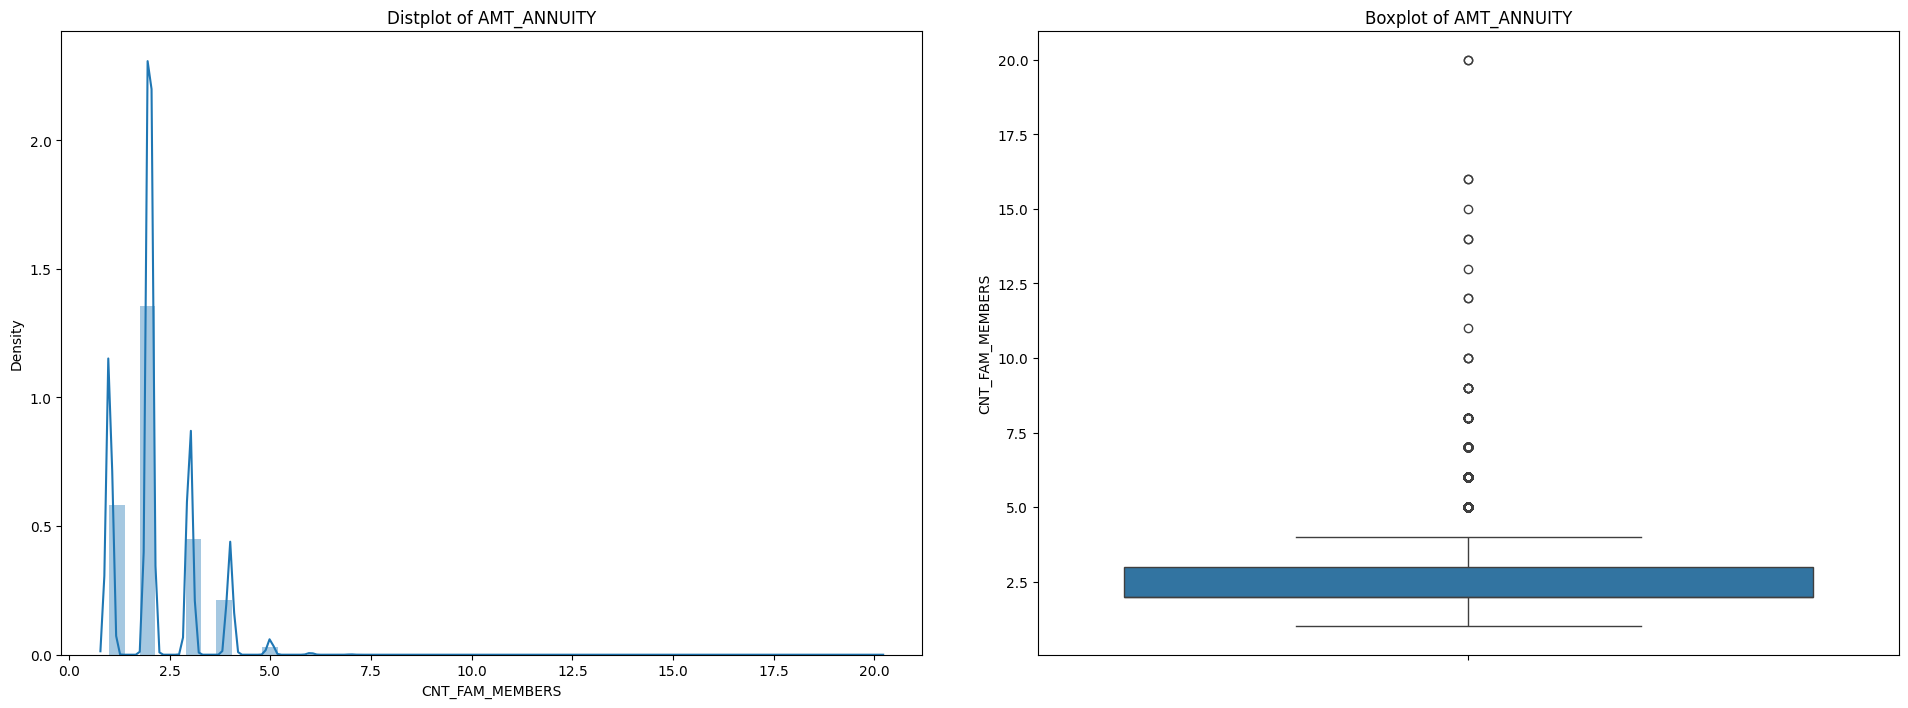

In [176]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.subplots(1,2 ,figsize = (20,8))

    plt.subplot(121)
    sns.distplot(df[df['AMT_ANNUITY'] < 110047.50].CNT_FAM_MEMBERS)
    pltname = 'Distplot of AMT_ANNUITY'
    plt.title(pltname)

    plt.subplot(122)
    sns.boxplot(df[df['AMT_ANNUITY'] < 110047.50].CNT_FAM_MEMBERS)
    pltname = 'Boxplot of AMT_ANNUITY'
    plt.title(pltname)

    plt.tight_layout(pad = 4)
    plt.show()

#### Спостереження
- Дивлячись на дані, ми бачимо, що дохід понад 61704.0 (98% значення) є викидом
- Як діаграма розподілу, так і діаграма розмаху чітко показують нам ту саму тенденцію


#### Висновок
- Апліканти з AMT_ANNUITY понад 61704.0 (98% значення) є викидами

# Розбиття на біни безперервних колонок для аналізу

### Категоризація стовпця `AMT_GOODS_PRICE

In [177]:
df['AMT_GOODS_PRICE'].value_counts().sort_values(ascending = False).head()

AMT_GOODS_PRICE
450000.00    26300
225000.00    25282
675000.00    24962
900000.00    15416
270000.00    11428
Name: count, dtype: int64

In [178]:
(df['AMT_GOODS_PRICE'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

AMT_GOODS_PRICE
450000.00   8.55
225000.00   8.22
675000.00   8.12
900000.00   5.01
270000.00   3.72
Name: proportion, dtype: float64

Подивимось статистичний звіт для `AMT_GOODS_PRICE

In [179]:
df['AMT_GOODS_PRICE'].describe(percentiles = [0.25,0.75,0.99,0.9999])

count     307511.00
mean      538316.29
std       369288.98
min        40500.00
25%       238500.00
50%       450000.00
75%       679500.00
99%      1800000.00
99.99%   2933964.00
max      4050000.00
Name: AMT_GOODS_PRICE, dtype: float64

Розподілимо значення в `AMT_GOODS_PRICE` на 5 бінів і створимо новий стовпець `AMT_GOODS_PRICE_CATEGORY`.

In [180]:
df['AMT_GOODS_PRICE_CATEGORY'] = pd.cut(df['AMT_GOODS_PRICE'],
                                        bins = 5, labels = ['very low', 'low', 'medium', 'high', 'very high'])

Перевірка заповнення значень згідно з очікуванням

In [181]:
df['AMT_GOODS_PRICE_CATEGORY'].value_counts()

AMT_GOODS_PRICE_CATEGORY
very low     247251
low           56087
medium         4108
high             47
very high        18
Name: count, dtype: int64

### Категоризація стовпця `YEARS_BIRTH`

Ми будемо класифікувати `YEARS_BIRTH` замість `DAYS_BIRTH`, оскільки роки легше інтерпретувати, ніж дні

In [182]:
df['YEARS_BIRTH'].value_counts().sort_values(ascending = False).head()

YEARS_BIRTH
39    9023
38    8793
37    8727
40    8602
41    8495
Name: count, dtype: int64

In [183]:
(df['YEARS_BIRTH'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

YEARS_BIRTH
39   2.93
38   2.86
37   2.84
40   2.80
41   2.76
Name: proportion, dtype: float64

Подивимось статистичний звіт для  `YEARS_BIRTH`

In [184]:
df['YEARS_BIRTH'].describe(percentiles = [0.25,0.75,0.99,0.9999])

count    307511.00
mean         43.94
std          11.96
min          21.00
25%          34.00
50%          43.00
75%          54.00
99%          67.00
99.99%       69.00
max          69.00
Name: YEARS_BIRTH, dtype: float64

Категоризуймо значення з `YEARS_BIRTH` у новий стовпець `YEARS_BIRTH_CATEGORY`.

In [185]:
df['YEARS_BIRTH_CATEGORY'] = df['YEARS_BIRTH'].apply(age_cat)

Перевірка заповнення значень згідно з очікуванням

In [186]:
df['YEARS_BIRTH_CATEGORY'].value_counts().sort_values(ascending = False)

YEARS_BIRTH_CATEGORY
30-40    82770
40-50    75509
50-60    67955
20-30    48869
60-70    32408
Name: count, dtype: int64

### Категоризація стовпця `YEARS_REGISTRATION`

Ми будемо класифікувати `YEARS_REGISTRATION` замість `DAYS_REGISTRATION`, оскільки роки легше інтерпретувати, ніж дні

In [187]:
df['YEARS_REGISTRATION'].value_counts().sort_values(ascending = False).head()

YEARS_REGISTRATION
1     15661
2     15564
3     13894
13    12866
12    12697
Name: count, dtype: int64

In [188]:
(df['YEARS_REGISTRATION'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

YEARS_REGISTRATION
1    5.09
2    5.06
3    4.52
13   4.18
12   4.13
Name: proportion, dtype: float64

Подивимось статистичний звіт для `YEARS_REGISTRATION`

In [189]:
df['YEARS_REGISTRATION'].describe(percentiles = [0.25,0.75,0.99,0.9999])

count    307511.00
mean         13.66
std           9.66
min           0.00
25%           6.00
50%          12.00
75%          20.00
99%          38.00
99.99%       54.25
max          68.00
Name: YEARS_REGISTRATION, dtype: float64

Категоризуймо значення з `YEARS_REGISTRATION` в новий стовпець `YEARS_REGISTRATION_CATEGORY`.

In [190]:
df['YEARS_REGISTRATION_CATEGORY'] = df['YEARS_REGISTRATION'].apply(age_cat)

Перевірка заповнення значень згідно з очікуванням

In [191]:
df['YEARS_REGISTRATION_CATEGORY'].value_counts().sort_values(ascending = False)

YEARS_REGISTRATION_CATEGORY
0-20     230697
20-30     59288
30-40     16051
40-50      1406
50-60        60
60-70         9
Name: count, dtype: int64

# Зберігання оновлених даних зі стисненням

In [192]:
filename = "application_data_processed"
compression_options = dict(method='zip', archive_name=f'{filename}.csv')
df.to_csv(f'{filename}.zip', compression=compression_options, index=False)

In [193]:
# якщо Вам треба буде зчитати оновлені дані - замініть шлях на свій і можна зчитати їх тут
# df = pd.read_csv('drive/MyDrive/Machine Learning для людей/data/credit/application_data_processed.zip')

# Перевірка дисбалансу для цільового стовпця `TARGET`

### Аналіз стовпця `TARGET`

In [194]:
df['TARGET'].value_counts().sort_values(ascending = False)

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [195]:
df['TARGET'].value_counts(normalize = True).sort_values(ascending = False) * 100

TARGET
0   91.93
1    8.07
Name: proportion, dtype: float64

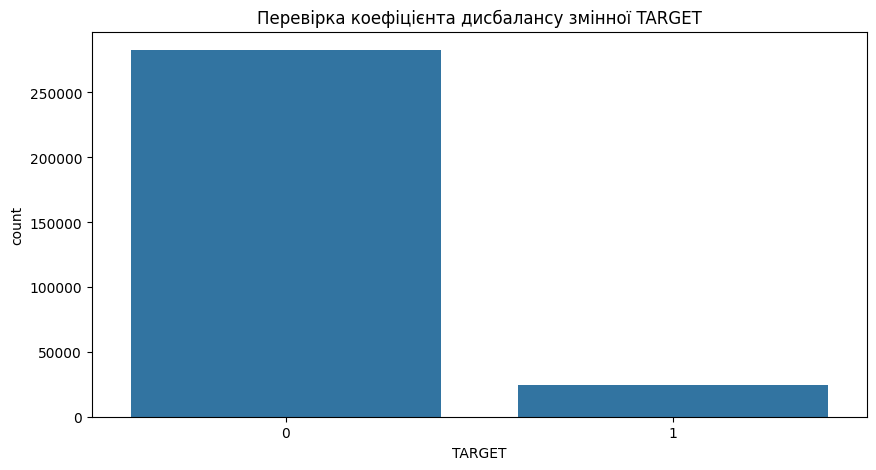

In [196]:
plt.figure(figsize = (10,5))
sns.countplot(x = df['TARGET'], data = df)
plt.title('Перевірка коефіцієнта дисбалансу змінної TARGET')
plt.show()

**Спостереження**

- Ми маємо дисбаланс у змінній `TARGET` на основі % спостережень
 - Значення `TARGET` 1 - це клієнт, який має труднощі з оплатою (прострочення платежу більше ніж на X днів принаймні за одним з перших Y платежів за кредитом). Це лише 8,07% даних
 - Значення `TARGET` 0 - всі інші випадки, окрім 1. Це 91,93% даних

# Розподіл даних на основі `TARGET`

### Створіть новий фрейм даних зі значенням `TARGET` 1
- Значення `TARGET` 1 представляє клієнта з платіжними труднощами (він/вона прострочив платіж більш ніж на X днів принаймні по одному з перших Y платежів за кредитом). Це лише 8,07% даних

In [197]:
df1 = df[df['TARGET'] == 1]

In [198]:
df1.TARGET.value_counts()

TARGET
1    24825
Name: count, dtype: int64

### Створити новий фрейм даних зі значенням `TARGET` 0
- Значення `TARGET` 0 представляє всі інші випадки, крім 1. Це 91.93% даних

In [199]:
df0 = df[df['TARGET'] == 0]

In [200]:
df0.TARGET.value_counts()

TARGET
0    282686
Name: count, dtype: int64

# Одномірний аналіз категоріальних змінних

### Аналіз стовпця `NAME_CONTRACT_TYPE`

In [207]:
df[df.TARGET == 0].NAME_CONTRACT_TYPE.value_counts(normalize=True) * 100

NAME_CONTRACT_TYPE
Cash loans        90.21
Revolving loans    9.79
Name: proportion, dtype: float64

In [208]:
df[df.TARGET == 1].NAME_CONTRACT_TYPE.value_counts(normalize=True) * 100

NAME_CONTRACT_TYPE
Cash loans        93.54
Revolving loans    6.46
Name: proportion, dtype: float64

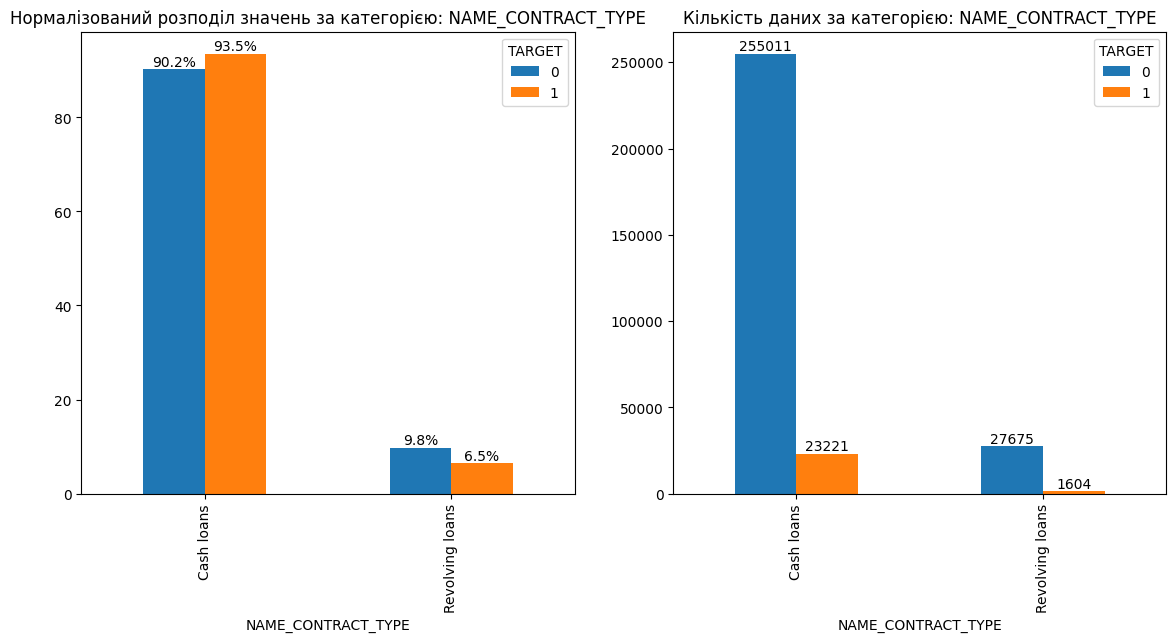

In [201]:
uni_cat_target_compare(df, 'NAME_CONTRACT_TYPE')

**Спостереження**

- Дивлячись на гістограми, ми не бачимо суттєвих відмінностей у `NAME_CONTRACT_TYPE` між клієнтами, які мають труднощі з оплатою, та клієнтами, які платять вчасно

**Висновок**
- Колонка `NAME_CONTRACT_TYPE` не надає жодних переконливих доказів на користь клієнтів, які мають труднощі з оплатою АБО вчасно сплачують

# ДЗ 4. Одновимірний аналіз категоріальної колонки

Проведіть подібний аналіз для колонок
- CODE_GENDER
- FLAG_OWN_CAR
- NAME_INCOME_TYPE

Опціонально
- NAME_EDUCATION_TYPE
- NAME_FAMILY_STATUS


Чи є вплив цих змінних на цільову та який саме?

## Аналіз CODE_GENDER

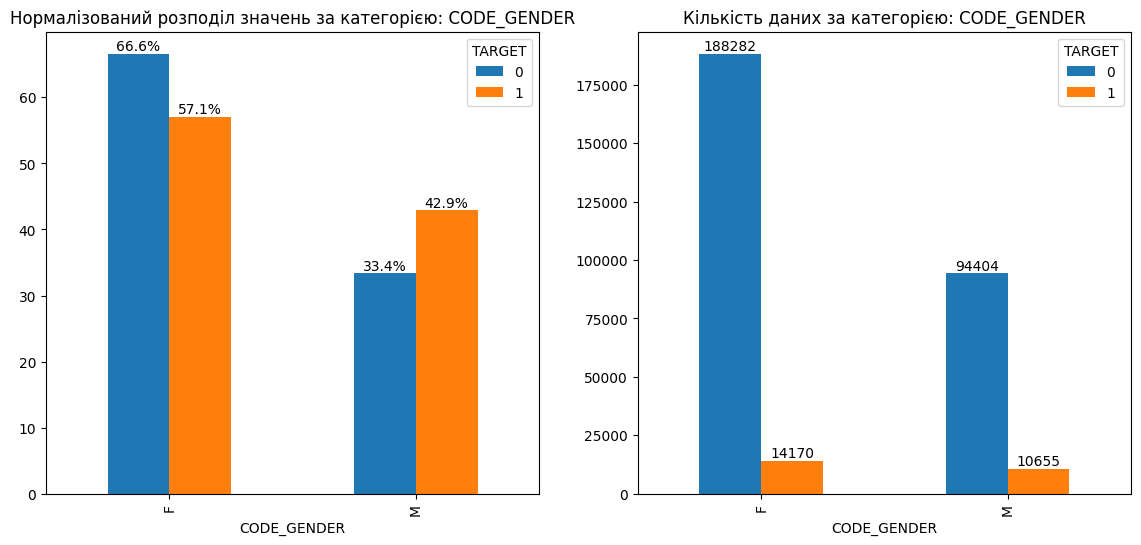

In [202]:
uni_cat_target_compare(df, 'CODE_GENDER')

### Спостереження
- Дивлячись на гістограми, ми бачимо відмінність у 10% `CODE_GENDER` між клієнтами, які мають труднощі з оплатою, та клієнтами, які платять вчасно

### Висновок
- Колонка `CODE_GENDER` показує що жінки частіше вчасно сплачують за чоловіків

## Аналіз FLAG_OWN_CAR

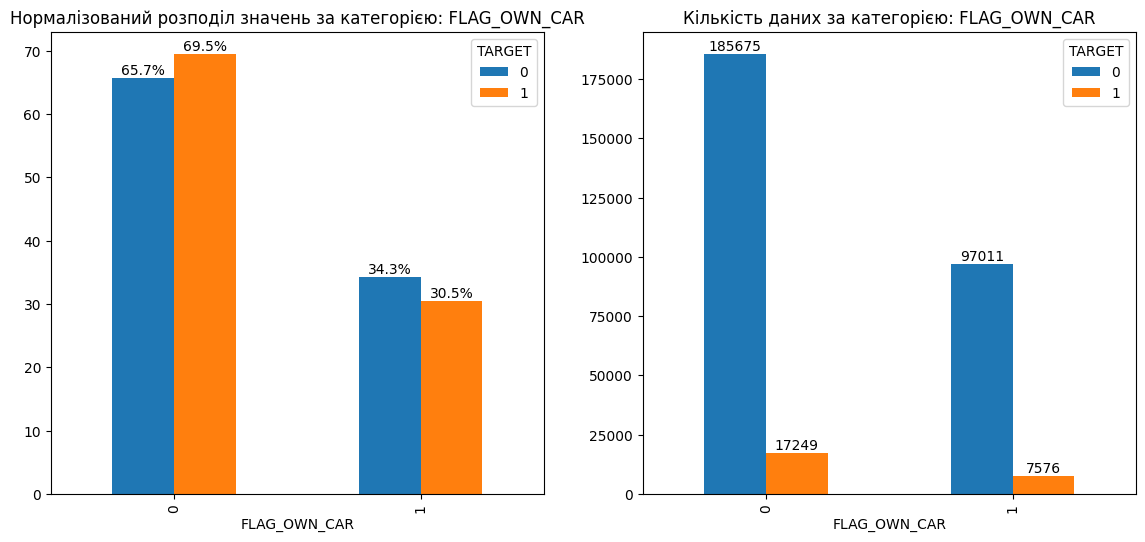

In [203]:
uni_cat_target_compare(df, 'FLAG_OWN_CAR')

### Спостереження
- Дивлячись на гістограми, ми не бачимо суттєвих відмінностей у `FLAG_OWN_CAR` між клієнтами, які мають труднощі з оплатою, та клієнтами, які платять вчасно

### Висновок
- Колонка `FLAG_OWN_CAR` не надає жодних переконливих доказів на користь клієнтів, які мають труднощі з оплатою АБО вчасно сплачують

## Аналіз NAME_INCOME_TYPE

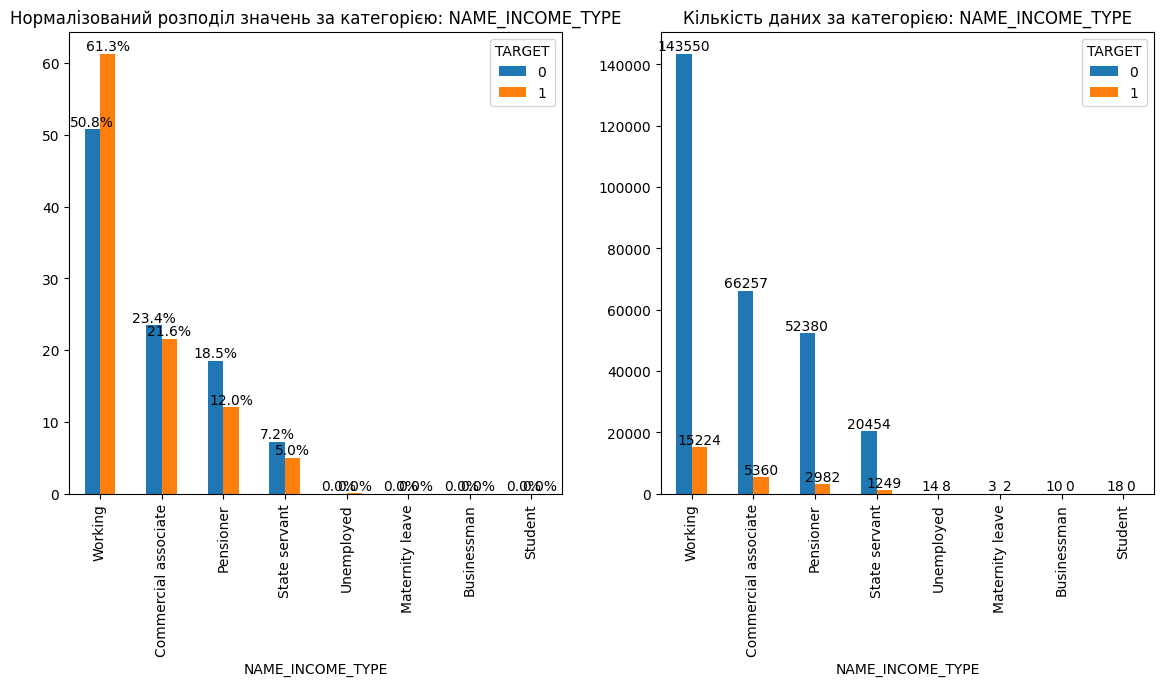

In [209]:
uni_cat_target_compare(df, 'NAME_INCOME_TYPE')

In [210]:
66257 + 52380 + 20454

139091

### Спостереження
- Дивлячись на гістограми, ми бачимо відмінність 10% для працюючих та 6.5% для пенсіонерів у `NAME_INCOME_TYPE` між клієнтами, які мають труднощі з оплатою, та клієнтами, які платять вчасно

### Висновок
- Колонка `NAME_INCOME_TYPE` показує що більше проблем з виплатами є серед працюючих клієнтів

## Аналіз NAME_EDUCATION_TYPE

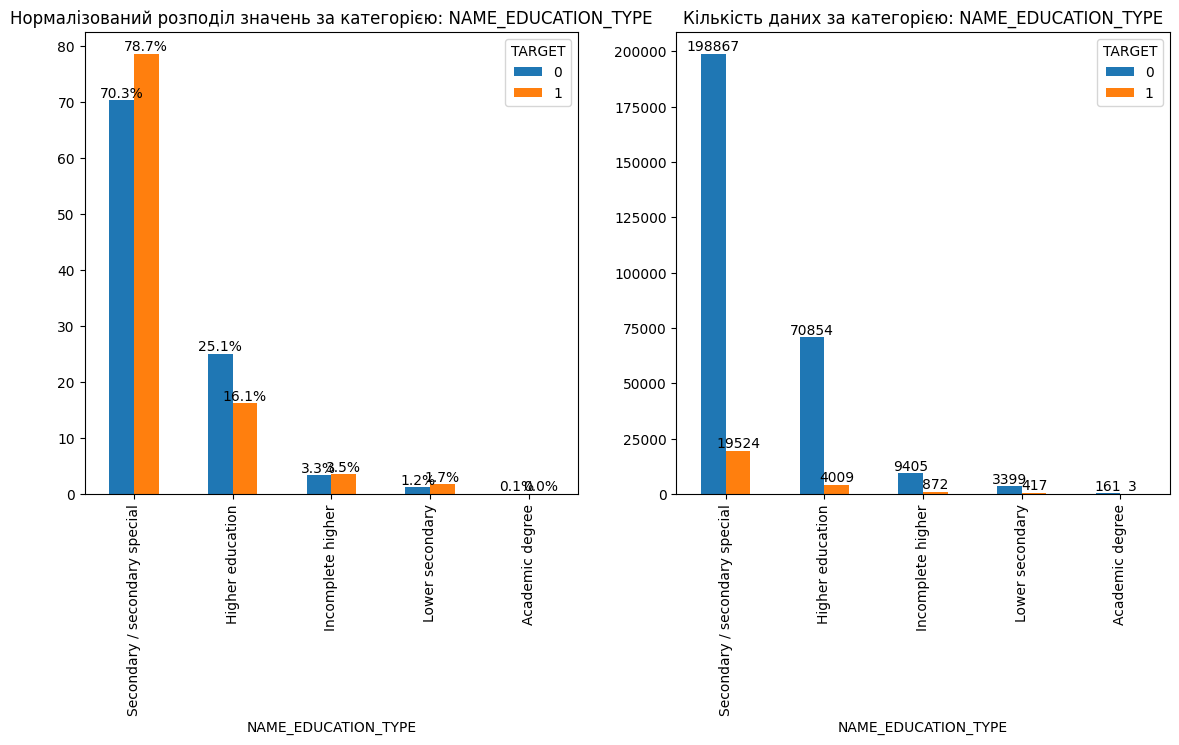

In [205]:
uni_cat_target_compare(df, 'NAME_EDUCATION_TYPE')

### Спостереження
- Дивлячись на гістограми, ми бачимо відмінність 8% для тих хто має середню / середню спеціальну освіту та 10% - з вищою освітою у `NAME_EDUCATION_TYPE` між клієнтами, які мають труднощі з оплатою, та клієнтами, які платять вчасно

### Висновок
- Колонка `NAME_EDUCATION_TYPE` показує що більше проблем з виплатами є серед клієнтів з середньою / середньою спеціальною освітою

## Аналіз NAME_FAMILY_STATUS

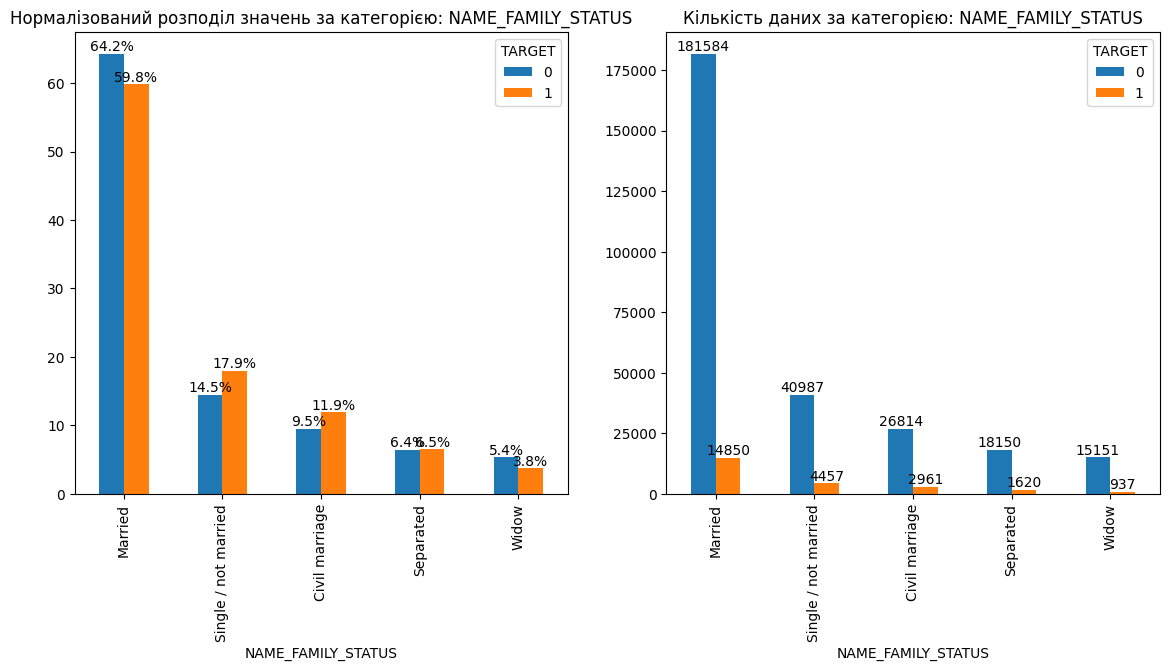

In [206]:
uni_cat_target_compare(df, 'NAME_FAMILY_STATUS')

### Спостереження
- Дивлячись на гістограми, ми не бачимо суттєвих відмінностей у `NAME_FAMILY_STATUS` між клієнтами, які мають труднощі з оплатою, та клієнтами, які платять вчасно

### Висновок
- Колонка `NAME_FAMILY_STATUS` не надає жодних переконливих доказів на користь клієнтів, які мають труднощі з оплатою АБО вчасно сплачують

# Кореляційний аналіз числових змінних

### Побудова кореляційної матриці для випадків із платіжними труднощами

In [ ]:
df1.select_dtypes(include='number').shape

(24825, 67)

Є 67 числових стовпчиків. Створимо кореляційну матрицб `corr` для кращого перегляду результатів

In [ ]:
corr_df1 = df1.select_dtypes(include='number').corr()

In [ ]:
corr_df1.head()

,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_CHANGED,YEARS_BIRTH,YEARS_REGISTRATION,YEARS_ID_PUBLISH,YEARS_LAST_PHONE_CHANGE
TARGET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_CAR,NaN,1.00,0.02,0.07,0.02,0.10,0.14,0.10,0.03,-0.07,-0.11,-0.07,0.02,NaN,0.11,-0.02,0.00,-0.00,0.03,0.11,-0.01,-0.01,0.01,-0.00,0.02,0.02,-0.01,0.04,0.06,0.04,-0.01,0.01,-0.01,0.01,-0.01,0.05,0.01,-0.07,NaN,-0.01,-0.07,0.00,0.20,-0.00,NaN,-0.02,NaN,0.05,0.00,0.02,0.01,0.00,-0.00,-0.01,0.00,0.01,0.00,-0.01,0.00,0.03,-0.01,-0.01,NaN,-0.07,-0.07,0.02,0.05
FLAG_OWN_REALTY,NaN,0.02,1.00,0.02,0.01,-0.01,0.00,-0.02,0.03,0.11,0.06,0.01,-0.02,NaN,-0.06,-0.14,-0.01,-0.05,0.03,0.03,-0.01,-0.01,-0.12,-0.05,-0.04,-0.02,-0.07,-0.07,-0.03,-0.00,0.02,0.04,0.01,0.04,0.00,-0.03,0.00,-0.05,NaN,-0.01,0.04,-0.01,-0.01,0.00,NaN,-0.02,NaN,-0.02,-0.03,-0.02,-0.05,-0.00,-0.07,-0.02,-0.01,-0.01,0.00,-0.00,0.02,-0.00,0.02,0.06,NaN,0.11,0.01,-0.02,-0.03
CNT_CHILDREN,NaN,0.07,0.02,1.00,0.00,-0.00,0.03,-0.01,-0.03,-0.26,-0.19,-0.15,0.03,NaN,0.19,0.05,0.00,-0.02,0.01,0.89,0.04,0.04,-0.02,-0.02,-0.02,-0.01,-0.00,0.05,0.05,-0.01,-0.02,0.03,0.00,0.03,-0.01,-0.01,-0.01,0.06,NaN,-0.02,-0.13,-0.00,0.03,0.00,NaN,-0.01,NaN,0.00,-0.00,0.00,-0.00,-0.01,0.00,-0.00,-0.00,0.00,-0.00,-0.01,-0.01,-0.01,-0.02,-0.04,NaN,-0.26,-0.15,0.03,-0.01
AMT_INCOME_TOTAL,NaN,0.02,0.01,0.00,1.00,0.04,0.05,0.04,0.01,-0.00,-0.01,-0.00,0.00,NaN,0.01,-0.01,-0.00,-0.00,0.01,0.01,-0.02,-0.02,0.01,0.01,0.01,0.01,-0.00,-0.00,-0.00,0.01,-0.02,-0.00,-0.01,-0.00,-0.00,0.00,0.00,0.00,NaN,-0.00,-0.01,-0.00,0.02,0.00,NaN,-0.00,NaN,0.01,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,NaN,-0.00,0.00,0.00,0.00


Перегляд повної кореляційної матриці

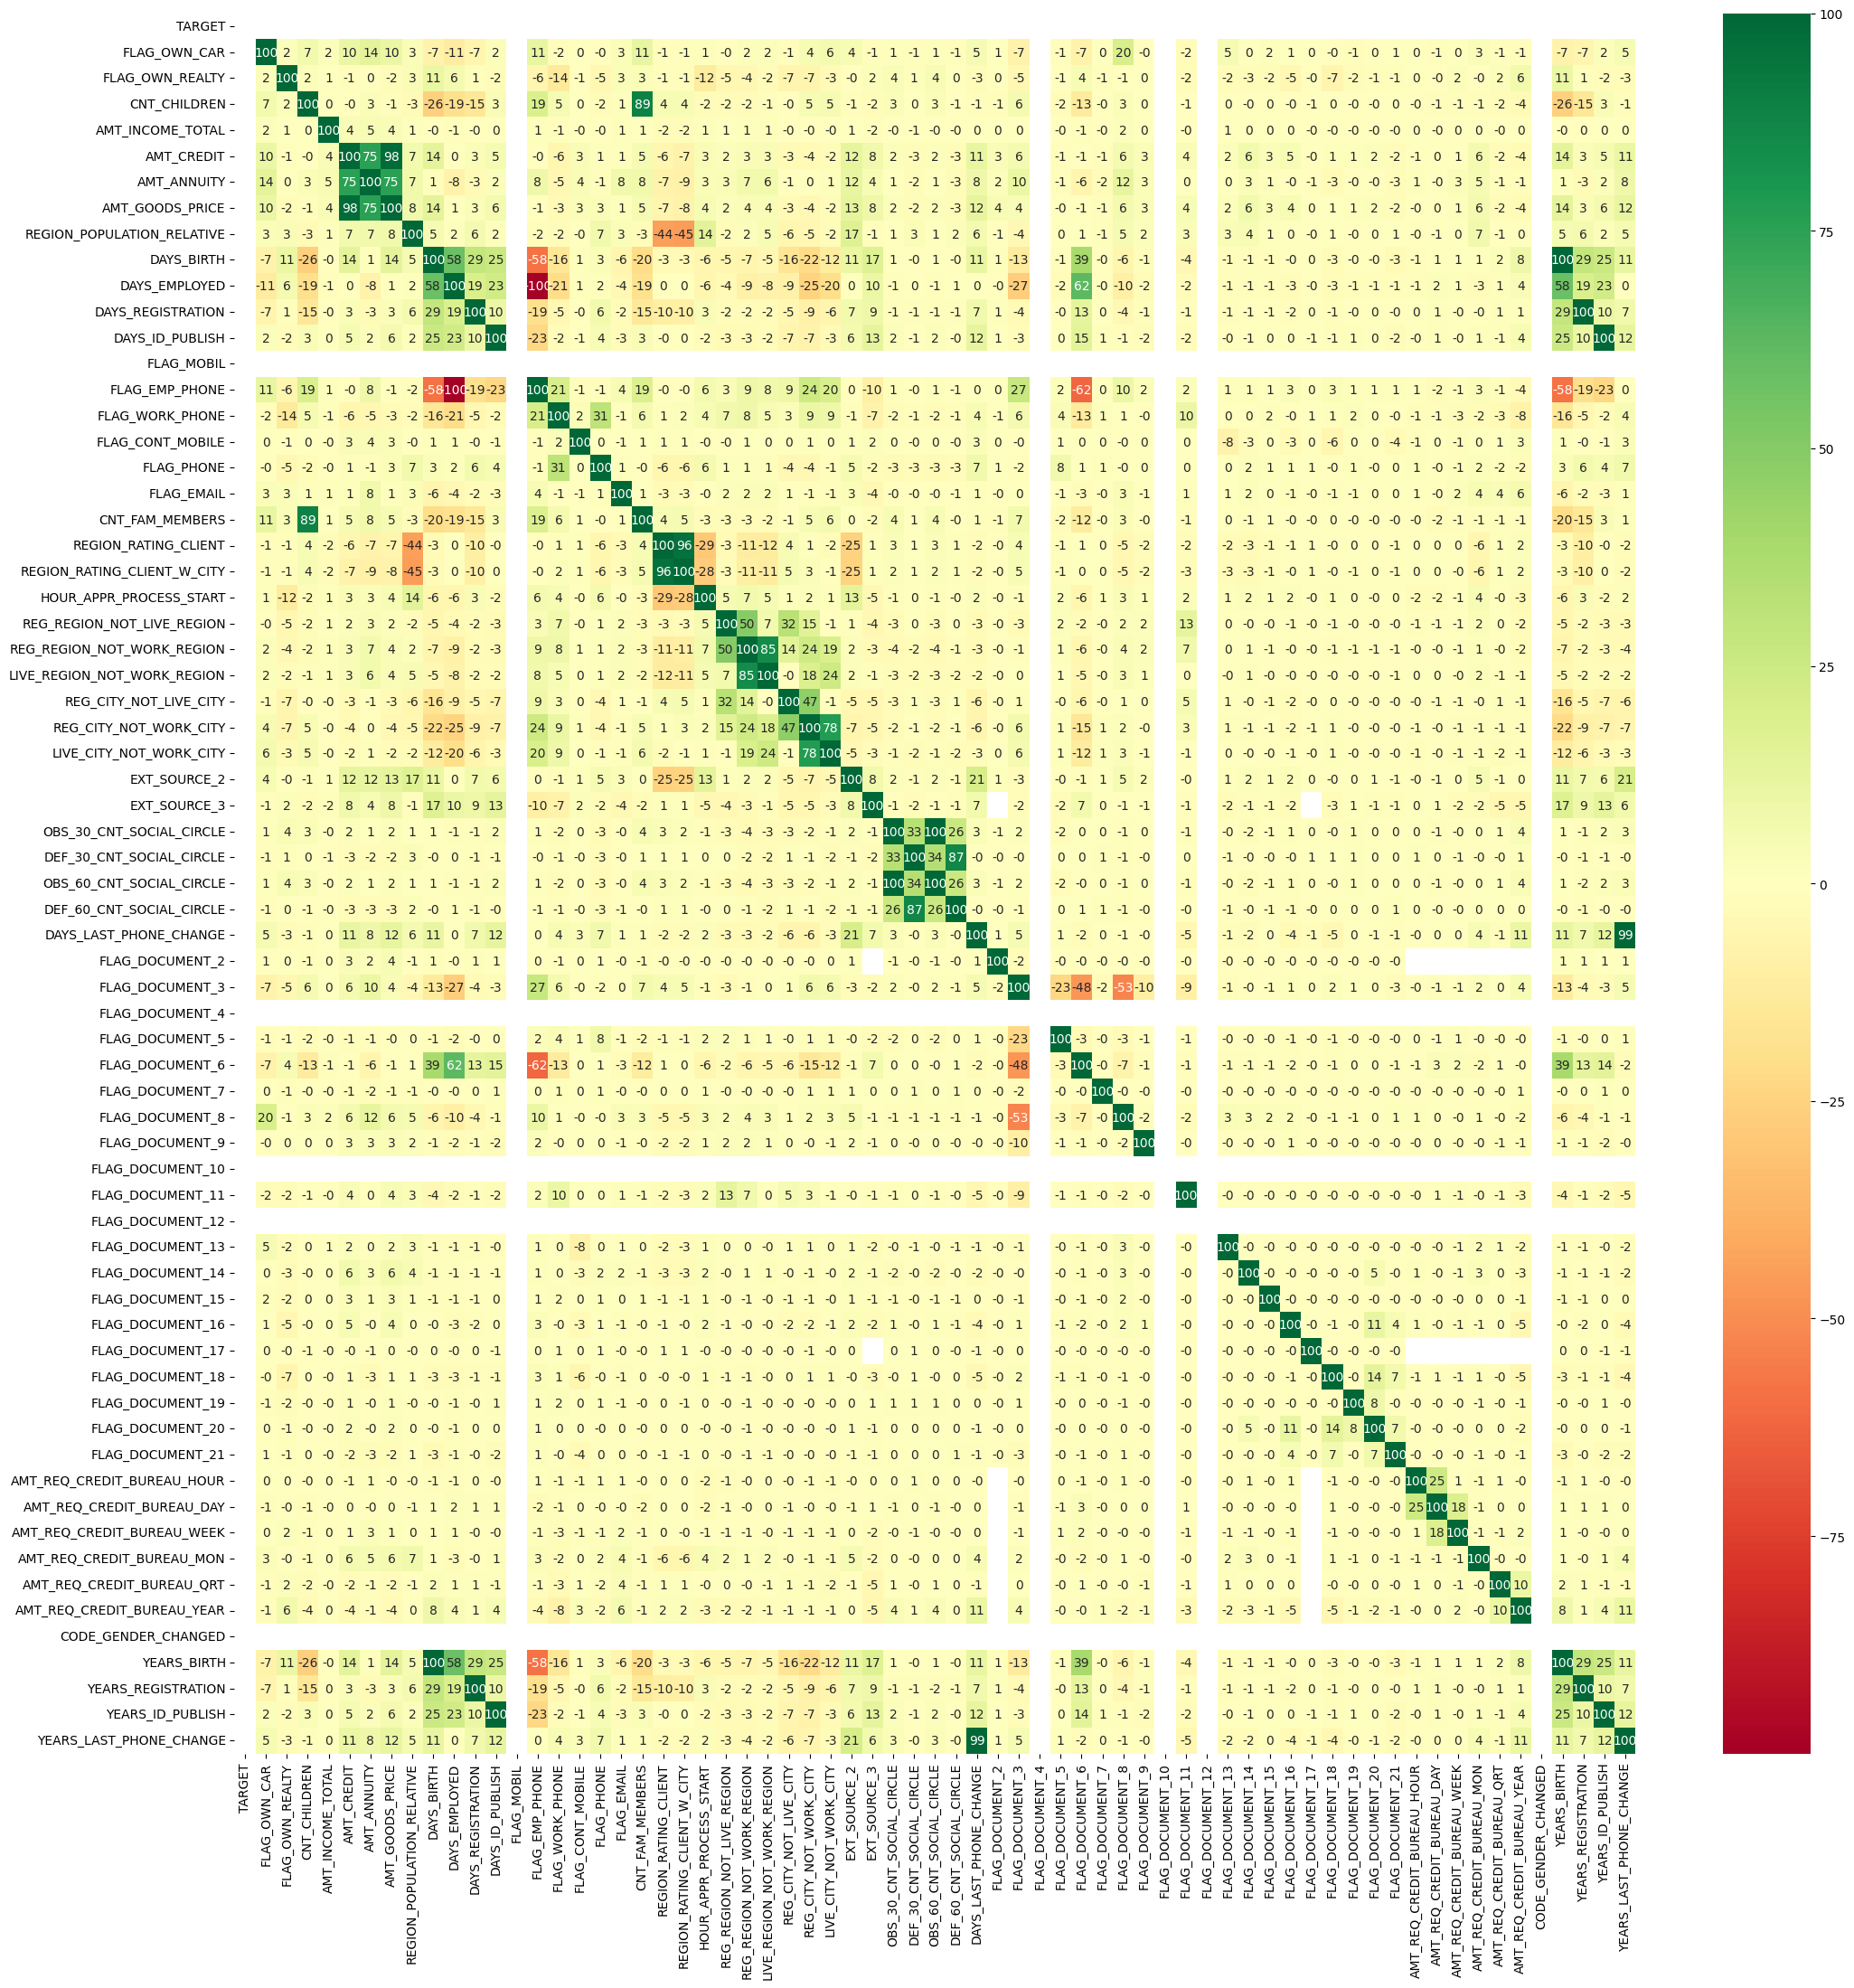

In [ ]:
plt.figure(figsize = (25,25))
sns.heatmap(data = corr_df1*100, annot = True, cmap = "RdYlGn", cbar = True, fmt='.0f')
plt.show()

Створимо теплову карту для перегляду кореляцій вище 80% і 99,99%

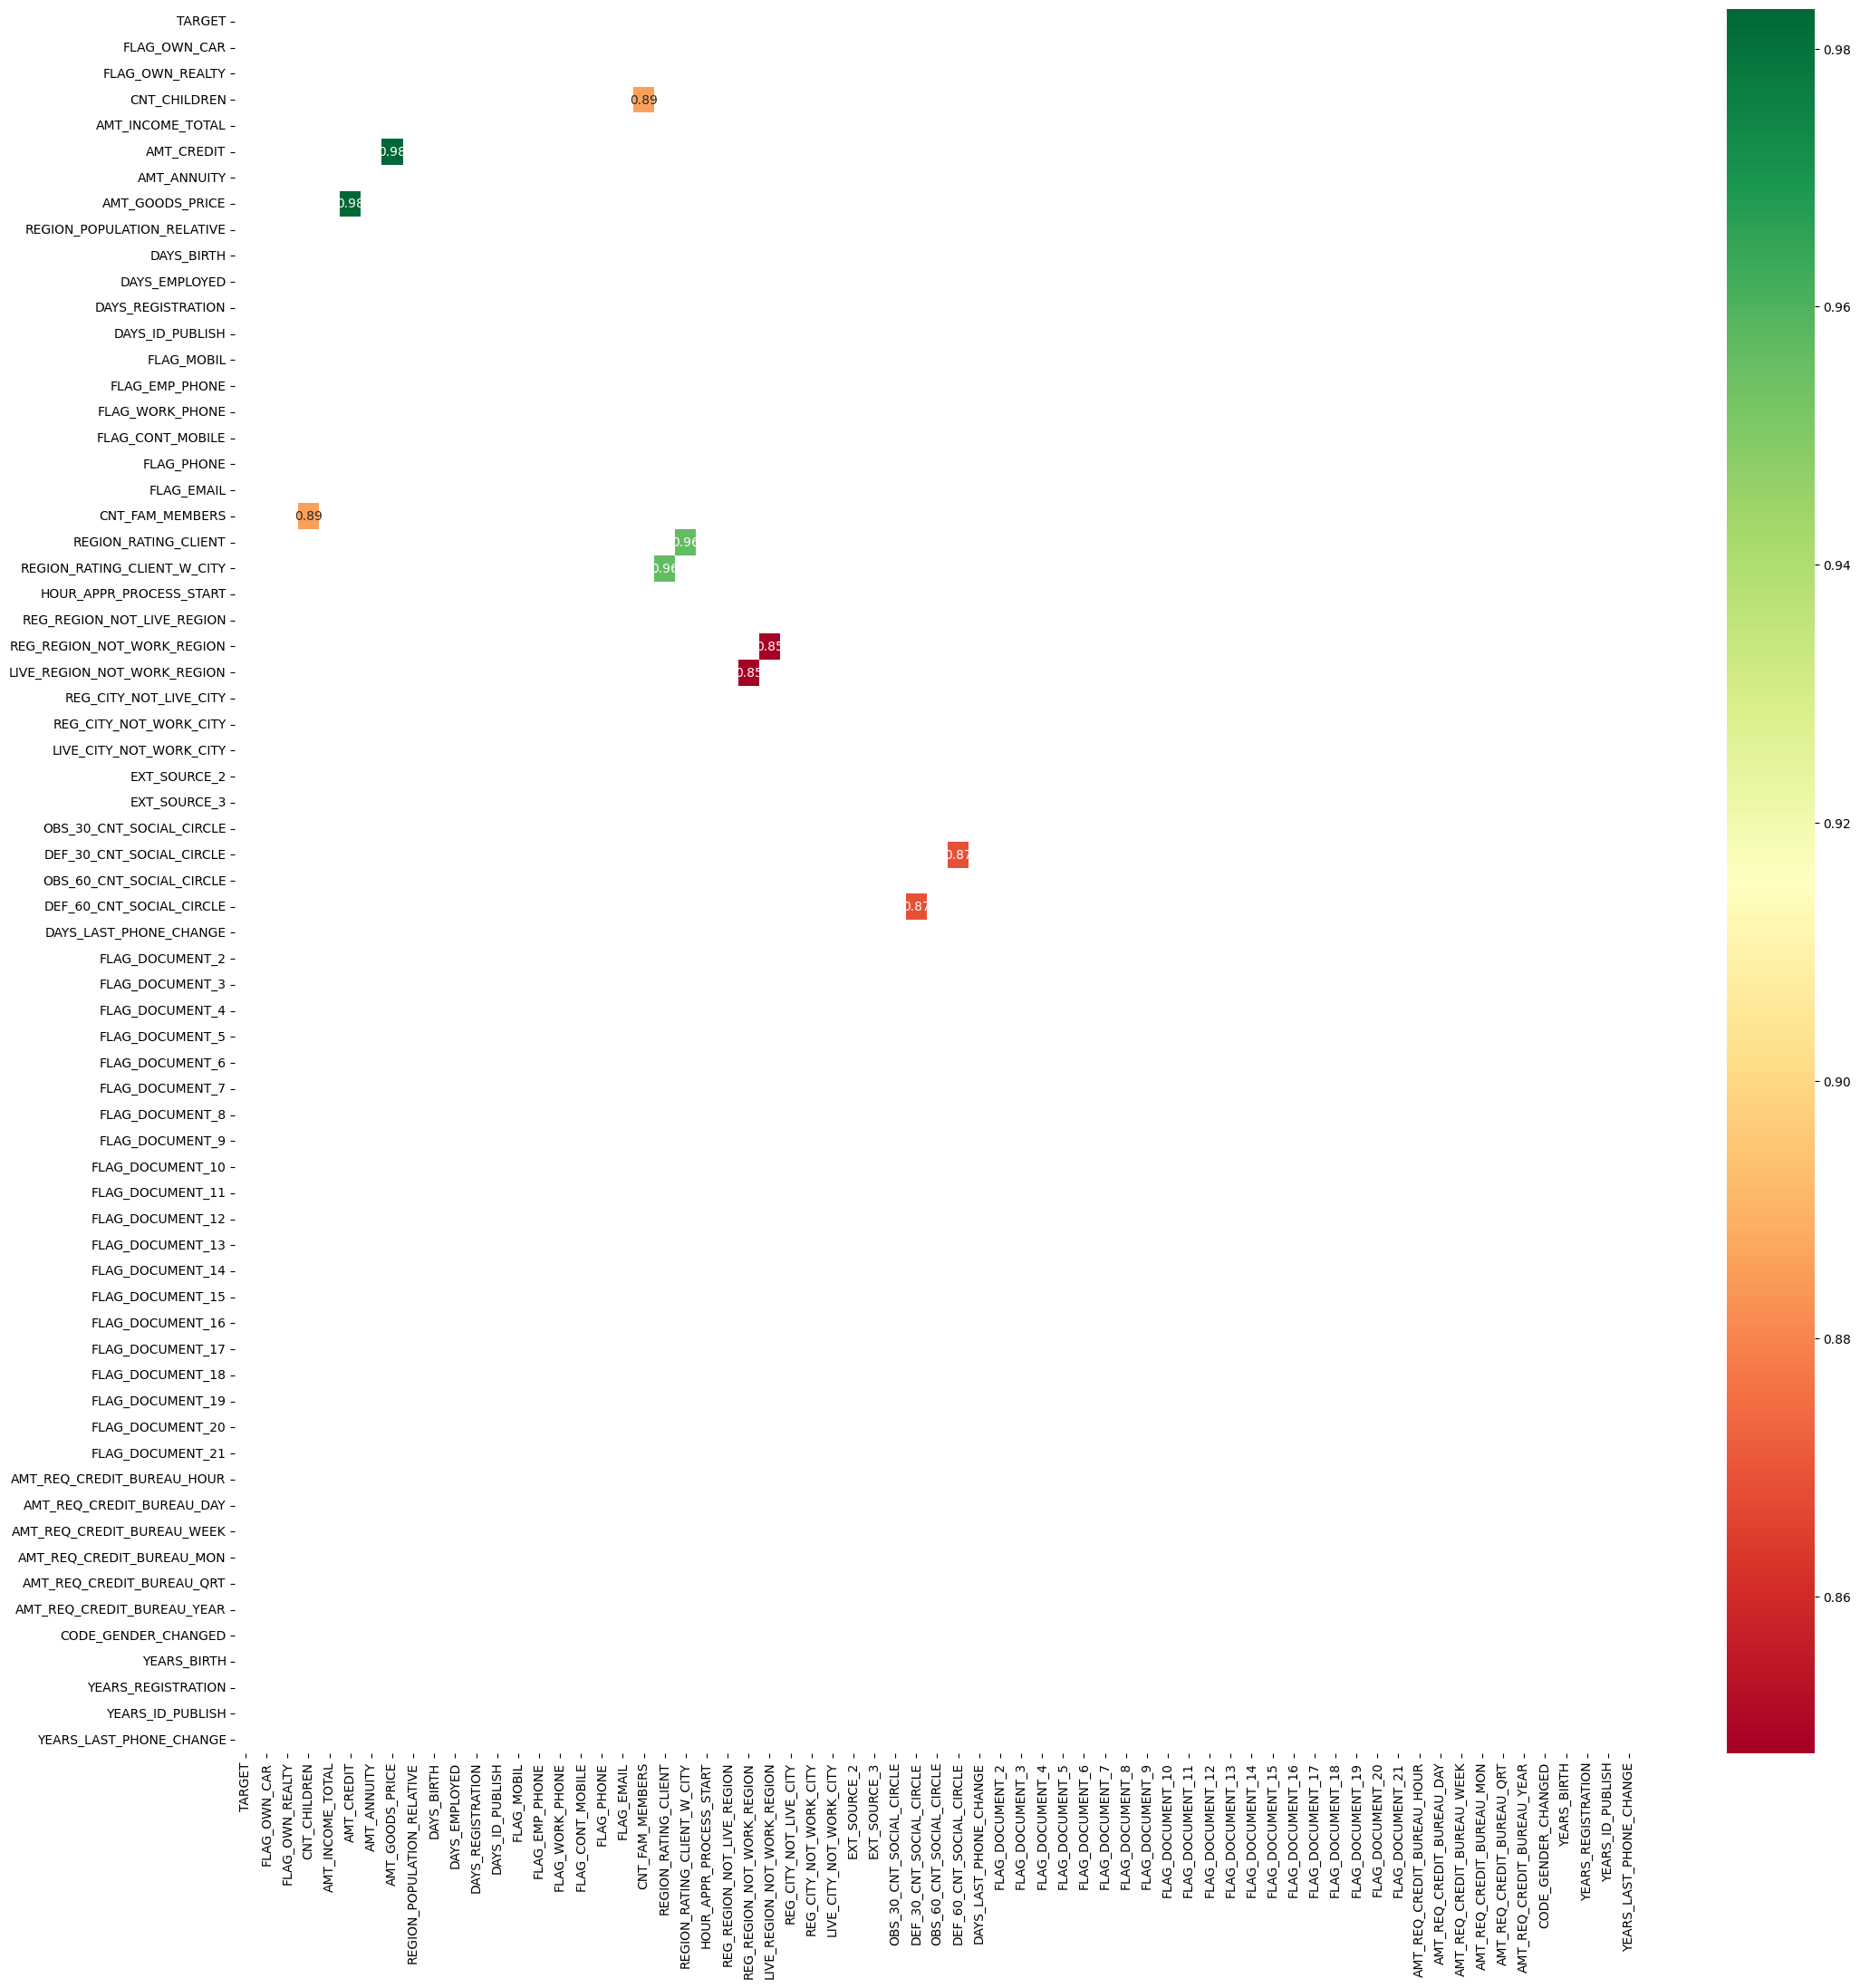

In [ ]:
plt.figure(figsize = (25,25))
sns.heatmap(data = corr_df1[(corr_df1 >= 0.8) & (corr_df1 < 0.99)], annot = True, cmap = "RdYlGn", cbar = True, fmt='.2f')
plt.show()

### Подивимось на 10 найкращих кореляцій для випадків із платіжними труднощами

In [ ]:
corr_df1[corr_df1 <= 0.99].unstack().sort_values(ascending = False).head(22)

AMT_CREDIT                   AMT_GOODS_PRICE               0.98
AMT_GOODS_PRICE              AMT_CREDIT                    0.98
REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT          0.96
REGION_RATING_CLIENT         REGION_RATING_CLIENT_W_CITY   0.96
CNT_FAM_MEMBERS              CNT_CHILDREN                  0.89
CNT_CHILDREN                 CNT_FAM_MEMBERS               0.89
DEF_30_CNT_SOCIAL_CIRCLE     DEF_60_CNT_SOCIAL_CIRCLE      0.87
DEF_60_CNT_SOCIAL_CIRCLE     DEF_30_CNT_SOCIAL_CIRCLE      0.87
LIVE_REGION_NOT_WORK_REGION  REG_REGION_NOT_WORK_REGION    0.85
REG_REGION_NOT_WORK_REGION   LIVE_REGION_NOT_WORK_REGION   0.85
REG_CITY_NOT_WORK_CITY       LIVE_CITY_NOT_WORK_CITY       0.78
LIVE_CITY_NOT_WORK_CITY      REG_CITY_NOT_WORK_CITY        0.78
AMT_GOODS_PRICE              AMT_ANNUITY                   0.75
AMT_ANNUITY                  AMT_GOODS_PRICE               0.75
                             AMT_CREDIT                    0.75
AMT_CREDIT                   AMT_ANNUITY

Оскільки у нас є комбінації, що повторюються, дивлячись на наведену вище таблицю і видаляючи дублі, ми отримуємо топ-10 кореляцій, як показано нижче:

- AMT_GOODS_PRICE -              AMT_CREDIT                    0.98
- REGION_RATING_CLIENT -         REGION_RATING_CLIENT_W_CITY   0.96
- CNT_FAM_MEMBERS -              CNT_CHILDREN                  0.89
- DEF_60_CNT_SOCIAL_CIRCLE -     DEF_30_CNT_SOCIAL_CIRCLE      0.87
- REG_REGION_NOT_WORK_REGION -   LIVE_REGION_NOT_WORK_REGION   0.85
- LIVE_CITY_NOT_WORK_CITY -      REG_CITY_NOT_WORK_CITY        0.78
- AMT_ANNUITY -                  AMT_GOODS_PRICE               0.75
- AMT_ANNUITY -                  AMT_CREDIT                    0.75
- DAYS_EMPLOYED -                FLAG_DOCUMENT_6               0.62
- DAYS_BIRTH -                   DAYS_EMPLOYED                 0.58

### Побудова кореляційної матриці для випадків із вчасними платежеми

In [ ]:
df0.select_dtypes(include='number').shape

(282686, 67)

Є 67 числових стовпчиків. Створимо кореляційну матрицю `corr` для кращого перегляду результатів

In [ ]:
corr_df0 = df0.select_dtypes(include='number').corr()

In [ ]:
corr_df0.head()

Створимо теплову карту для перегляду кореляцій вище 80% і 99,99%

In [ ]:
plt.figure(figsize = (25,25))
sns.heatmap(data = corr_df0[(corr_df0 >= 0.8) & (corr_df0 < 0.9999)], annot = True, cmap = "RdYlGn", cbar = True, fmt='.2f')
plt.show()

### Подивимось на 10 найкращих кореляцій для вчасних платежів

In [ ]:
corr_df0[corr_df0 <= 0.99].unstack().sort_values(ascending = False).head(28)

AMT_CREDIT                   AMT_GOODS_PRICE               0.99
AMT_GOODS_PRICE              AMT_CREDIT                    0.99
REGION_RATING_CLIENT         REGION_RATING_CLIENT_W_CITY   0.95
REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT          0.95
CNT_CHILDREN                 CNT_FAM_MEMBERS               0.88
CNT_FAM_MEMBERS              CNT_CHILDREN                  0.88
LIVE_REGION_NOT_WORK_REGION  REG_REGION_NOT_WORK_REGION    0.86
REG_REGION_NOT_WORK_REGION   LIVE_REGION_NOT_WORK_REGION   0.86
DEF_60_CNT_SOCIAL_CIRCLE     DEF_30_CNT_SOCIAL_CIRCLE      0.86
DEF_30_CNT_SOCIAL_CIRCLE     DEF_60_CNT_SOCIAL_CIRCLE      0.86
LIVE_CITY_NOT_WORK_CITY      REG_CITY_NOT_WORK_CITY        0.83
REG_CITY_NOT_WORK_CITY       LIVE_CITY_NOT_WORK_CITY       0.83
AMT_ANNUITY                  AMT_GOODS_PRICE               0.78
AMT_GOODS_PRICE              AMT_ANNUITY                   0.78
AMT_ANNUITY                  AMT_CREDIT                    0.77
AMT_CREDIT                   AMT_ANNUITY

Оскільки у нас є комбінації, що повторюються, дивлячись на наведену вище таблицю і видаляючи дублі, ми отримуємо топ-10 кореляцій, як показано нижче:

- AMT_GOODS_PRICE              AMT_CREDIT                    0.99
- REGION_RATING_CLIENT         REGION_RATING_CLIENT_W_CITY   0.95
- CNT_FAM_MEMBERS              CNT_CHILDREN                  0.88
- REG_REGION_NOT_WORK_REGION   LIVE_REGION_NOT_WORK_REGION   0.86
- DEF_30_CNT_SOCIAL_CIRCLE     DEF_60_CNT_SOCIAL_CIRCLE      0.86
- LIVE_CITY_NOT_WORK_CITY      REG_CITY_NOT_WORK_CITY        0.83
- AMT_ANNUITY                  AMT_GOODS_PRICE               0.78
- AMT_ANNUITY                  AMT_CREDIT                    0.77
- DAYS_BIRTH                   DAYS_EMPLOYED                 0.63
- DAYS_EMPLOYED                FLAG_DOCUMENT_6               0.60

### Порівняємо 10 найкращих кореляцій між випадками із платіжними труднощами та вчасними платежами

**Спостереження**

- Топ-10 кореляцій для Труднощів з оплатою та Вчасних платежів однакові, за винятком незначних відмінностей у відсотках кореляції
- Найвища кореляція для комбінації `AMT_GOODS_PRICE` та `AMT_CREDIT`.
- Для набору даних "Труднощі з оплатою" кореляція між `AMT_GOODS_PRICE` та `AMT_CREDIT` становить 0,98
- Для набору даних "Вчасні платежі" кореляція між `AMT_GOODS_PRICE` та `AMT_CREDIT` становить 0,99

# Одновимірний аналіз числових змінних

### Аналіз стовпця `AMT_CREDIT`

#### Пошук викидів в `AMT_CREDIT` при випадках із платіжними труднощами

Розрахунок IQR (Inter Quartile range)

In [ ]:
Q1 = df1['AMT_CREDIT'].quantile(0.25)
Q3 = df1['AMT_CREDIT'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

448915.5


Значення *до* (Q1 - 1.5 * IQR) та *після* (Q3 + 1.5 * IQR) є викидами.

In [ ]:
Min_value1 = (Q1 - 1.5 * IQR)
Max_value1 = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value1))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value1))

Мінімальне значення, до якого існують викиди: -388973.25
Максимальне значення, після якого існують викиди: 1406688.75


#### Пошук викидів в `AMT_CREDIT` при випадках із вчасними оплатами

Розрахунок IQR (Inter Quartile range)

In [ ]:
Q1 = df0['AMT_CREDIT'].quantile(0.25)
Q3 = df0['AMT_CREDIT'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

540000.0


Значення *до* (Q1 - 1.5 * IQR) та *після* (Q3 + 1.5 * IQR) є викидами.

In [ ]:
Min_value0 = (Q1 - 1.5 * IQR)
Max_value0 = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value0))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value0))

Мінімальне значення, до якого існують викиди: -540000.0
Максимальне значення, після якого існують викиди: 1620000.0


Видалення викидів і побудова діаграми розподілу

In [ ]:
def kde_no_outliers(df0, df1, Max_value0, Max_value1, column):
  plt.figure(figsize = (14,6))
  sns.kdeplot(df1[df1[column] <= Max_value1][column],label = 'Payment difficulties')
  sns.kdeplot(df0[df0[column] <= Max_value0][column],label = 'On-Time Payments')
  plt.ticklabel_format(style='plain', axis='x')
  plt.xticks(rotation = 45)
  plt.legend()
  plt.show()

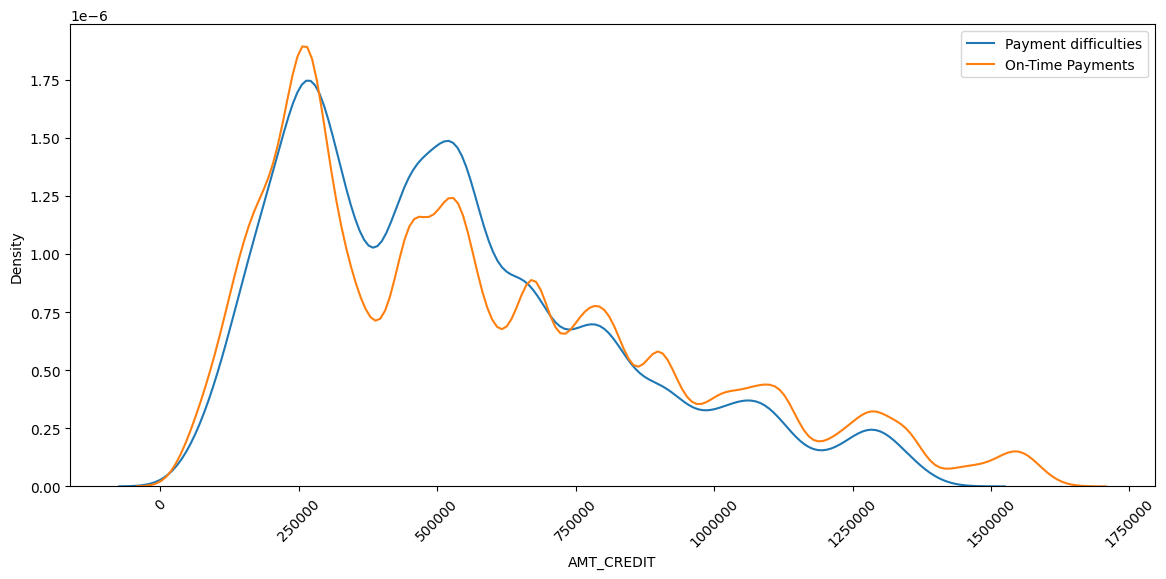

In [ ]:
kde_no_outliers(df0, df1, Max_value0, Max_value1, 'AMT_CREDIT')

**Спостереження**

- Для `AMT_CREDIT` від 250000 до приблизно 650000 більше клієнтів мають труднощі з оплатою
- Для `AMT_CREDIT` > 750000 більше клієнтів, які вчасно здійснюють платежі

# ДЗ 5. Одновимірний аналіз числової колонки

 Проведіть подібний до прикладу одновимірний аналіз (виявлення викидів, їх усунення та побудова KDE  графіку) для числових змінних
- `YEARS_BIRTH`
- `AMT_GOODS_PRICE`
- `DAYS_EMPLOYED`

Опціонально
- `CNT_CHILDREN`
- `AMT_INCOME_TOTAL`

Для цього винесіть функціонал для аналізу у функцію та викличіть функцію для кожної двійки змінних.

Зробіть висновки з аналізу.

# Двовимірний/Багатовимірний аналіз

## Неперервні vs неперервні змінні

### Аналіз стовпця `AMT_GOODS_PRICE` vs `AMT_CREDIT`

**Пошук викидів для ствопця `AMT_GOODS_PRICE ` для групи із платіжними труднощами**

In [ ]:
max_value1_AMT_GOODS_PRICE = outlier_range(df1,'AMT_GOODS_PRICE')
max_value1_AMT_GOODS_PRICE

1329750.0

**Пошук викидів для ствопця `AMT_CREDIT` для групи із платіжними труднощами**

In [ ]:
max_value1_AMT_CREDIT = outlier_range(df1,'AMT_CREDIT')
max_value1_AMT_CREDIT

1406688.75

**Пошук викидів для `AMT_GOODS_PRICE `для групи із вчасними оплатами**

In [ ]:
max_value0_AMT_GOODS_PRICE = outlier_range(df0,'AMT_GOODS_PRICE')
max_value0_AMT_GOODS_PRICE

1363500.0

**Пошук викидів для `AMT_CREDIT `для групи із вчасними оплатами**

In [ ]:
max_value0_AMT_CREDIT = outlier_range(df0,'AMT_CREDIT')
max_value0_AMT_CREDIT

1620000.0

Побудова діаграми розсіювання для порівняння з видаленими викидами

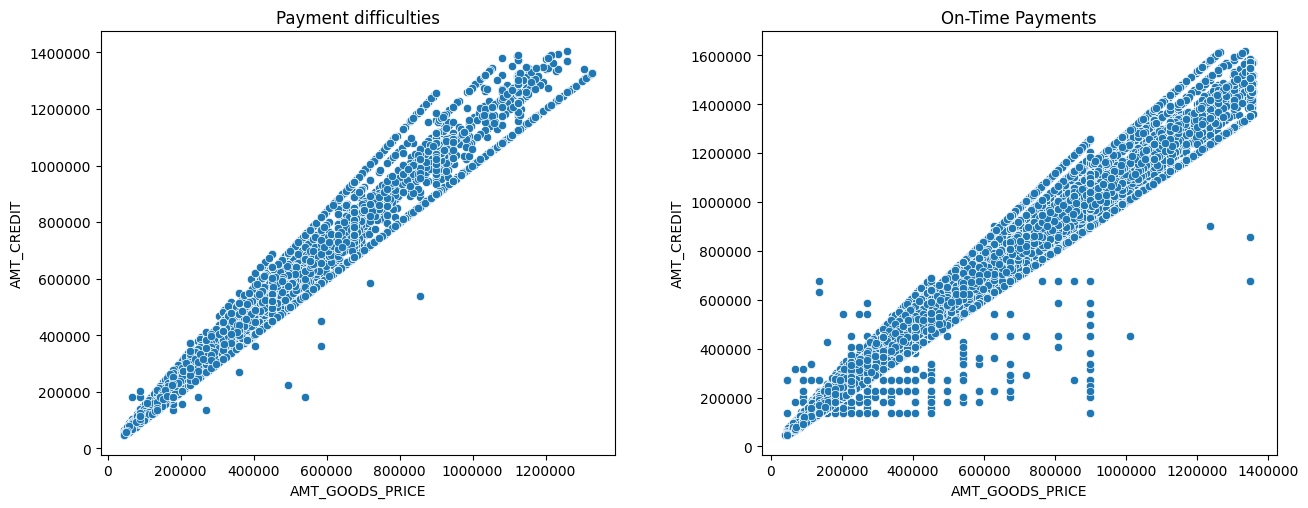

In [ ]:
plt.figure(figsize = (14, 6))

plt.subplot(1,2,1)
plt.title('Payment difficulties')
sns.scatterplot(x = df1[df1['AMT_GOODS_PRICE'] < max_value1_AMT_GOODS_PRICE].AMT_GOODS_PRICE,
                y = df1[df1['AMT_CREDIT'] < max_value1_AMT_CREDIT].AMT_CREDIT, data = df1)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')

plt.subplot(1,2,2)
plt.title('On-Time Payments')
sns.scatterplot(x = df0[df0['AMT_GOODS_PRICE'] < max_value0_AMT_GOODS_PRICE].AMT_GOODS_PRICE,
                y = df0[df0['AMT_CREDIT'] < max_value0_AMT_CREDIT].AMT_CREDIT, data = df0)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout(pad = 4)
plt.show()

**Спостереження**
- AMT_GOODS_PRICE та AMT_CREDIT мають сильну позитивну кореляцію. Це означає, що зі збільшенням ціни товару зростає і сума кредиту

# ДЗ 6. Кореляційний аналіз для пари числових змінних

Проведіть подібний до прикладу кореляційний аналіз для пар змінних
- AMT_ANNUITY і AMT_CREDIT
- DAYS_EMPLOYED і AMT_INCOME_TOTAL
- AMT_CREDIT і DAYS_BIRTH

Для цього винесіть функціонал для аналізу у функцію та викличіть функцію для кожної двійки змінних.
Зробіть висновок про наявність кореляції між змінними.

## Неперервні та категоріальні змінні

In [ ]:
def draw_boxplot(df, categorical, continuous, max_continuous, title, hue_column, subplot_position):
    """
    Малює блок-діаграму для заданого DataFrame, категоріальної та неперервної змінної.
    """
    plt.subplot(1, 2, subplot_position)
    plt.title(title)
    red_diamond = dict(markerfacecolor='r', marker='D')
    sns.boxplot(x=categorical,
                y=df[df[continuous] < max_continuous][continuous],
                data=df,
                flierprops=red_diamond,
                order=sorted(df[categorical].unique(), reverse=True),
                hue=hue_column, hue_order=sorted(df[hue_column].unique(), reverse=True))
    plt.ticklabel_format(style='plain', axis='y')
    plt.xticks(rotation=90)

def bi_boxplot(categorical, continuous, max_continuous1, max_continuous0, hue_column):
    """
    Створює паралельні блок-діаграми для двох груп, визначених у наборі даних, на основі
    категоріальної та неперервної змінної, виділяючи відмінності за допомогою відтінків.
    """
    plt.figure(figsize=(16, 10))

    # Графік для першо групи "Труднощі з платежами" (Payment Difficulties)
    draw_boxplot(df1, categorical, continuous, max_continuous1, 'Payment Difficulties', hue_column, 1)

    # Графік для другої групи "Вчасні оплати" (On-Time Payments)
    draw_boxplot(df0, categorical, continuous, max_continuous0, 'On-Time Payments', hue_column, 2)

    plt.tight_layout(pad=4)
    plt.show()

### Аналіз стовпців `AMT_CREDIT` vs `NAME_EDUCATION_TYPE` vs `CODE_GENDER`

**Пошук викидів для `AMT_CREDIT `для групи із платіжними труднощами**

In [ ]:
max_value1_AMT_CREDIT = outlier_range(df1,'AMT_CREDIT')
max_value1_AMT_CREDIT

1406688.75

**Пошук викидів для `AMT_CREDIT ` для групи із вчасними платежами**

In [ ]:
max_value0_AMT_CREDIT = outlier_range(df0,'AMT_CREDIT')
max_value0_AMT_CREDIT

1620000.0

**Клієнт з платіжними труднощами**

In [ ]:
df1.groupby(by = ['NAME_EDUCATION_TYPE','CODE_GENDER']).AMT_CREDIT.describe().head()

count      mean       std       min  \
NAME_EDUCATION_TYPE CODE_GENDER                                         
Academic degree     F              3.00 950245.50 504711.38 544491.00   
Higher education    F           2438.00 648500.58 410415.70  47970.00   
                    M           1571.00 642070.94 409695.93  45000.00   
Incomplete higher   F            504.00 520150.35 352227.49  91692.00   
                    M            368.00 554723.82 347843.71  74628.00   

                                      25%       50%        75%        max  
NAME_EDUCATION_TYPE CODE_GENDER                                            
Academic degree     F           667660.50 790830.00 1153122.75 1515415.50  
Higher education    F           323595.00 545040.00  877500.00 2687355.00  
                    M           329202.00 545040.00  832797.00 2695500.00  
Incomplete higher   F           269550.00 450000.00  675000.00 2695500.00  
                    M           284400.00 497520.00  699976.12 2013840.00

**Клієнт зі вчасними платежами**

In [ ]:
df0.groupby(by = ['NAME_EDUCATION_TYPE','CODE_GENDER']).AMT_CREDIT.describe().head()

count      mean       std       min  \
NAME_EDUCATION_TYPE CODE_GENDER                                          
Academic degree     F              97.00 708770.74 463052.42 130824.00   
                    M              64.00 735235.38 497739.97  74182.50   
Higher education    F           47852.00 682485.00 456642.78  45000.00   
                    M           23002.00 713144.54 486073.66  45000.00   
Incomplete higher   F            5780.00 555340.53 385980.60  45000.00   

                                      25%       50%        75%        max  
NAME_EDUCATION_TYPE CODE_GENDER                                            
Academic degree     F           354469.50 607500.00 1006920.00 2463840.00  
                    M           309519.00 610056.00 1036890.00 1984500.00  
Higher education    F           302206.50 568057.50  916470.00 4050000.00  
                    M           315000.00 592560.00  973503.00 4050000.00  
Incomplete higher   F           253737.00 454500.00  760225.50 2517300.00

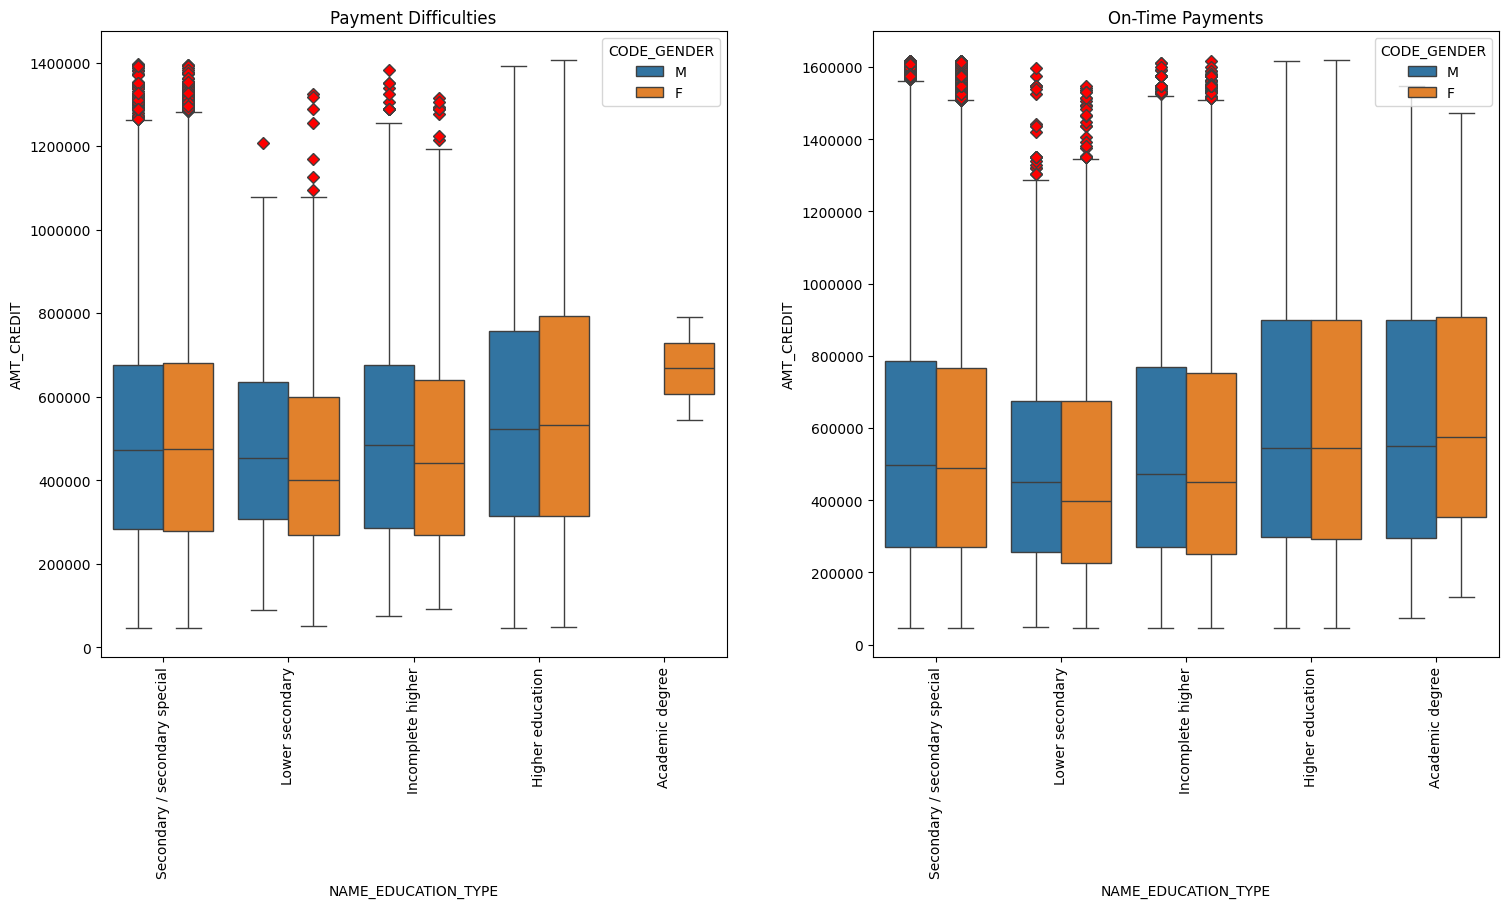

In [ ]:
bi_boxplot('NAME_EDUCATION_TYPE','AMT_CREDIT',max_value1_AMT_CREDIT, max_value0_AMT_CREDIT, 'CODE_GENDER')


**Спостереження**
- Клієнти з "академічним ступенем" мають широкий діапазон кредитів для своєчасних платежів, тоді як для клієнтів з проблемами з оплатою цей діапазон значно нижчий
- Якщо поглянути на зведену статистику, то клієнти з "академічним ступенем" та проблемами з оплатою беруть середній та медіанний кредит у значно більшому діапазоні, ніж клієнти з вчасною оплатою.
- Клієнти-чоловіки з "академічним ступенем" завжди сплачують кредит вчасно

 # ДЗ 7. Кореляційний аналіз між двома категоріальними змінними і числовою

Проведіть аналогічний кореляційний аналіз для трійок змінних

- AMT_INCOME_TOTAL vs NAME_FAMILY_STATUS vs CODE_GENDER
- AMT_INCOME_TOTAL vs YEARS_BIRTH_CATEGORY vs NAME_HOUSING_TYPE
- AMT_GOODS_PRICE vs NAME_INCOME_TYPE vs CODE_GENDER
- AMT_INCOME_TOTAL vs OCCUPATION_TYPE vs CODE_GENDER

Можете також проаналізувати додатково свою трійку :)

Для цього винесіть функціонал для аналізу у функцію та викличіть функцію для кожної трійки змінних.

Зробіть висновок про наявність кореляції між змінними.


## Залежності між категоріальними змінними

### Аналіз стовпців `NAME_INCOME_TYPE` vs `CODE_GENDER`

In [ ]:
def bi_countplot_target(df0, df1, column, hue_column):
  group_name = f'Нормалізований розподіл значень за категорією: {column}'
  print(group_name.upper())

  pltname = 'Клієнт зі складнощами щодо платності'
  unique_hue_values = df1[hue_column].unique()
  fig, axes = plt.subplots(nrows=1, ncols=2)
  fig.set_size_inches(14,4)

  proportions = df1.groupby(hue_column)[column].value_counts(normalize=True)
  proportions = (proportions*100).round(2)
  ax = proportions.unstack(hue_column).sort_values(
      by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[0], title=pltname)

  # анотація значень в барплоті
  for container in ax.containers:
      ax.bar_label(container, fmt='{:,.1f}%')

  pltname = 'Клієнти зі своєчасними платежами'
  unique_hue_values = df0[hue_column].unique()

  proportions = df0.groupby(hue_column)[column].value_counts(normalize=True)
  proportions = (proportions*100).round(2)
  ax = proportions.unstack(hue_column).sort_values(
      by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[1], title=pltname)

  for container in ax.containers:
      ax.bar_label(container, fmt='{:,.1f}%')

  plt.show()

  # ---------------
  group_name = f'Кількість значень за категорією: {column}'
  print(group_name.upper())

  pltname = 'Клієнт зі складнощами щодо платності'
  unique_hue_values = df1[hue_column].unique()
  fig, axes = plt.subplots(nrows=1, ncols=2)
  fig.set_size_inches(14,4)

  counts = df1.groupby(hue_column)[column].value_counts()
  ax = counts.unstack(hue_column).sort_values(
      by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[0], title=pltname)

  for container in ax.containers:
    ax.bar_label(container)

  pltname = 'Клієнти зі своєчасними платежами'
  unique_hue_values = df0[hue_column].unique()

  counts = df0.groupby(hue_column)[column].value_counts()
  ax = counts.unstack(hue_column).sort_values(
      by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[1], title=pltname)

  for container in ax.containers:
    ax.bar_label(container)

  plt.show()

НОРМАЛІЗОВАНИЙ РОЗПОДІЛ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ: NAME_INCOME_TYPE
КІЛЬКІСТЬ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ: NAME_INCOME_TYPE


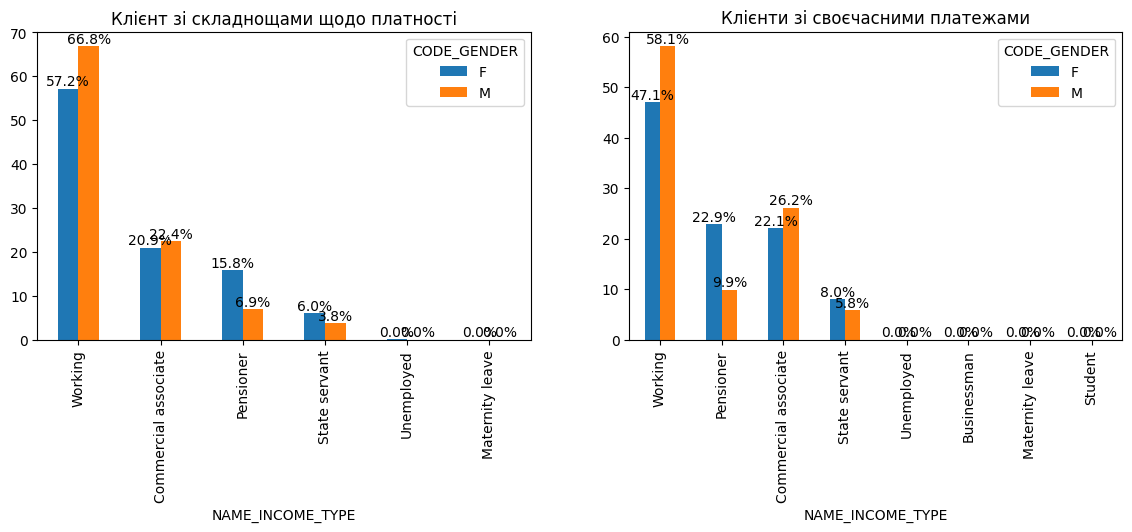

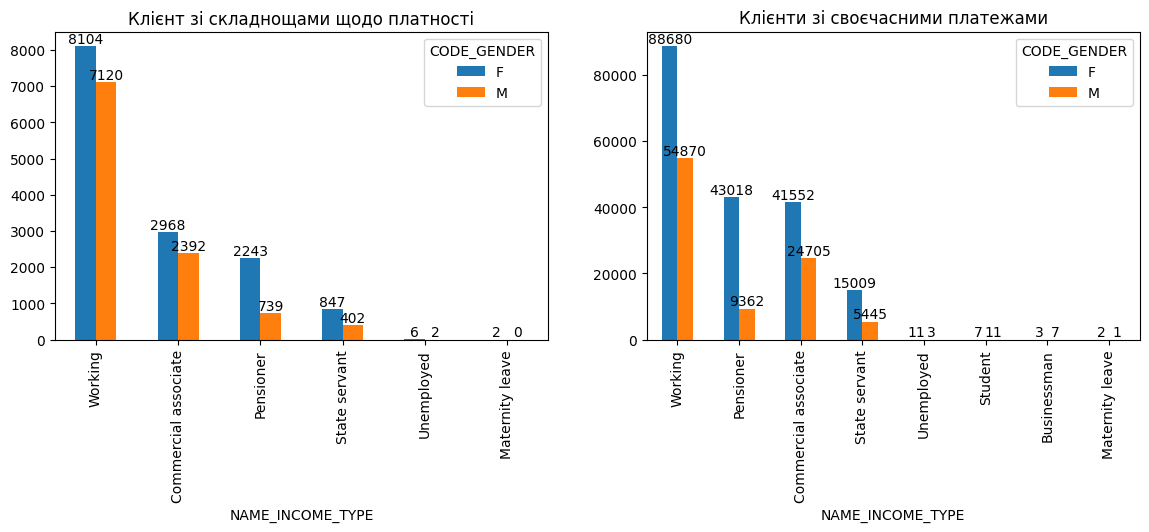

In [ ]:
bi_countplot_target(df0, df1, 'NAME_INCOME_TYPE','CODE_GENDER');

**Спостереження**
- Серед клієнтів, які мають складнощі з платністю людей категорії "Працюючі" та "Чоловіки" відсотково значно більше, ніж серед клієнтів, які складнощів з платністю не мають.
- Серед клієнтів, які мають складнощі з платністю людей категорії "Працюючі" та "Жінки" відсотково значно більше, ніж серед клієнтів, які складнощів з платністю не мають.
- Оскільки за обома CODE_GENDER бачимо, що найбільший відсоток клієнтів мають NAME_INCOME_TYPE Working - важливо проаналізувати ще додаткові змінні, які можуть впливати на те, чи буде клієнт мати складнощі з платежами, адже група клієнтів NAME_INCOME_TYPE Working - є в цілому найбільшою в наших даних.
- Клієнти категорії "Бізнесмени" та "Студенти" здійснюють платежі вчасно, хоча їхня історія невелика

# ДЗ 8. Аналіз взаємозалежностей між двома категоріальними змінними

Проведіть подібний до прикладу аналіз залежностей між категоріальними змінними для пар змінних

- NAME_EDUCATION_TYPE vs CODE_GENDER
- NAME_FAMILY_STATUS vs OCCUPATION_TYPE
- OCCUPATION_TYPE vs NAME_CONTRACT_TYPE

Опишіть спостереження щодо того, чи є цікаві знахідки стосовно цільової змінної з цього аналізу.

***
# ДЗ 9. Висновок з проведеного аналізу
Напишіть Ваш висновок з проведеного ананлізу, яким категоріям осіб Ви б видали кредит? Категорія може бути, наприклад, люди з такою-то освітою, з таким-то доходом, з таким-то досвідом роботи.

# Висновок: Категорії клієнтів, на яких слід орієнтуватися при наданні кредиту
